# Importazione librerie

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import Metriche_di_performance as mdp
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
from itertools import product
import numpy as np
import ccxt
import time

# Lettura dati Bitcoin

In [49]:
def download_and_plot(exchange_name, cryptos, timeframe, start_date, end_date, plot):
    
    exchange = getattr(ccxt, exchange_name)()  # Usa Bybit come exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{cryptos[0]} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

In [50]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
# dati = dati[['Date', 'Close']]
# dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
# dati

In [51]:
# # Bull market
# # data_inizio = '2020-12-01'
# # data_fine = '2021-04-30'

# # Mercato laterale
# # data_inizio = '2022-07-01'
# # data_fine = '2022-10-31'

# # Bear market
# # data_inizio = '2021-05-01'
# # data_fine = '2021-07-31'

# # Periodo personale
# data_inizio = '2021-02-01'
# data_fine = '2021-07-01'

# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

In [52]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
# data_inizio = '2021-05-01'
# data_fine = '2021-07-31'

# Periodo personale
data_inizio = '2024-02-01'
data_fine = '2024-07-01'

In [53]:
exchange_name = 'bybit'
chosen_cryptos = ['BTC']
timeframe_download = '1h'

data_frames = download_and_plot(exchange_name, chosen_cryptos, timeframe_download, data_inizio, data_fine, plot=False)

# Prepara il DataFrame `crypto_prices` con timestamp e prezzi di chiusura
crypto_prices = pd.DataFrame()
crypto_prices['timestamp'] = data_frames[chosen_cryptos[0]].index
for crypto in chosen_cryptos:
    crypto_prices[crypto] = data_frames[crypto]['close'].values

Scarico i dati per BTC/USDT dal 2024-02-01 al 2024-07-01...


In [54]:
dati = crypto_prices.rename(columns={'timestamp': 'Timestamp', 'BTC': 'Price'})
dati

Timestamp     Price
0    2024-02-01 00:00:00  42478.04
1    2024-02-01 01:00:00  41983.35
2    2024-02-01 02:00:00  42166.17
3    2024-02-01 03:00:00  42012.96
4    2024-02-01 04:00:00  42075.84
...                  ...       ...
3620 2024-06-30 20:00:00  61974.39
3621 2024-06-30 21:00:00  61933.64
3622 2024-06-30 22:00:00  62890.12
3623 2024-06-30 23:00:00  62772.83
3624 2024-07-01 00:00:00  62935.89

[3625 rows x 2 columns]

In [55]:
# dati.isna().sum().sum()

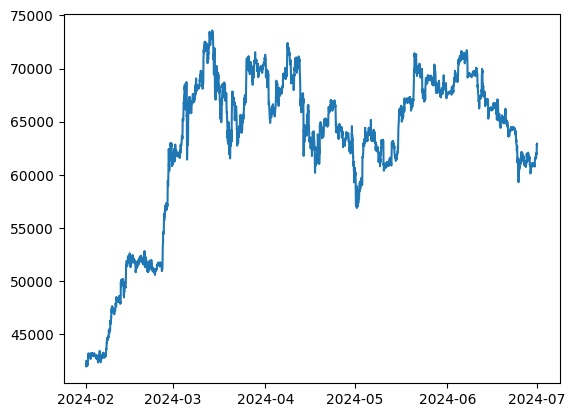

In [56]:
plt.plot(dati['Timestamp'], dati['Price'])

# Strategia 1

In [10]:
# Funzioni di supporto
def aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS):
    return (1 - perc_TS) * prezzo + perc_TS * prezzo_TS

def quanto_acquistare(A_a, B_a, variazione_perc, perc_primo_acquisto, liquidità_attuale, max_liquidità):
    if variazione_perc == 0:
        return min(max_liquidità * perc_primo_acquisto, liquidità_attuale)
    elif variazione_perc < 0:
        return min(max_liquidità * abs(variazione_perc) ** A_a / (B_a + (1 - B_a) * abs(variazione_perc) ** A_a), liquidità_attuale)
    print('Errore! Non può essere maggiore di 0 la variazione tra un acquisto e il successivo')

def quanto_vendere(A_v, B_v, variazione_vendite_inversa, perc_prima_vendita, bitcoin, max_bitcoin):
    if variazione_vendite_inversa == 0:
        return min(max_bitcoin * perc_prima_vendita, bitcoin)
    elif variazione_vendite_inversa < 0:
        return min(max_bitcoin * abs(variazione_vendite_inversa) ** A_v / (B_v + (1 - B_v) * abs(variazione_vendite_inversa) ** A_v), bitcoin)
    print('Errore! Non può essere maggiore di 0 la variazione inversa tra una vendita e la successiva')

In [11]:
def trading_doppio_TS(
    dati, 
    liquidità_iniziale, 
    bitcoin_iniziali, 
    perc_primo_acquisto,
    perc_prima_vendita,
    perc_TS, 
    perc_TS_inverso_setting,
    A_a,
    B_a,
    A_v,
    B_v
):

    # Dati iniziali
    liquidità = liquidità_iniziale
    bitcoin = bitcoin_iniziali
    prezzo_TS = dati['Price'].iloc[0]
    prezzo_TS_inverso = dati['Price'].iloc[0]
    prezzo_minimo = dati['Price'].iloc[0]
    prezzo_max_ciclo = dati['Price'].iloc[0]

    # Variabili di supporto
    prezzo_medio_acquisti = 0  # Media pesata dei prezzi degli acquisti
    quantità_acquisti = 0  # Quantità totale di BTC acquistati nella scia attuale
    valore_totale_acquisti = 0  # Valore totale degli acquisti effettuati
    in_scia_acquisti = False  # Flag per controllare se siamo in una scia di acquisti
    ultima_azione = "-"
    flag = False
    n_vendite_ciclo = 0
    max_liquidità = -np.inf
    max_bitcoin = -np.inf

    # Lista per registrare le transazioni
    transazioni = []

    # Itera sui dati
    for _, row in dati.iterrows():
        prezzo = row["Price"]
        timestamp = row["Timestamp"]
        azione = "-"
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0
        if liquidità > max_liquidità:
            max_liquidità = liquidità
        if bitcoin > max_bitcoin:
            max_bitcoin = bitcoin

        # Aggiorna il prezzo minimo nella scia corrente
        if in_scia_acquisti:
            if prezzo_minimo is None or prezzo < prezzo_minimo:
                prezzo_minimo = prezzo
                prezzo_TS_inverso = min(
                    prezzo * (1 + perc_TS_inverso_setting),
                    prezzo_medio_acquisti
                )

        # Controlla se l'acquisto è un "primo acquisto"
        if (ultima_azione == "Vendita" or ultima_azione == "-") and liquidità > 0:
            # Primo acquisto
            quantità_acquisto = min(perc_primo_acquisto * max_liquidità, liquidità) / prezzo
            liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
            liquidità -= liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = quantità_acquisto
            bitcoin += bitcoin_comprati_o_venduti
            prezzo_medio_acquisti = prezzo
            valore_totale_acquisti = liquidità_spesa_o_guadagnata
            quantità_acquisti = quantità_acquisto
            prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS)
            prezzo_minimo = prezzo
            prezzo_TS_inverso = min(prezzo_minimo * (1 + perc_TS_inverso_setting), prezzo_medio_acquisti) # in realtà al primo acquisto è ovvio che venga uguale a prezzo_medio_acquisti, quindi il calcolo del minimo è superfluo
            in_scia_acquisti = True
            ultima_azione = "Acquisto"
            azione = "Acquisto"
            prezzo_primo_acquisto = prezzo
            prezzo_precedente_acquisto = prezzo
            # n_acquisti_scia += 1
            n_vendite_ciclo = 0
            prezzo_max_ciclo = 0

        elif in_scia_acquisti and liquidità > 0:
            # Controlla se effettuare un acquisto in scia
            if prezzo < prezzo_medio_acquisti:
                if prezzo < prezzo_TS and prezzo >= prezzo_TS_inverso and prezzo < prezzo_precedente_acquisto: # direi che è superfluo chiedersi se prezzo < prezzo_TS perchè dovrebbe essere ovvio se prezzo < prezzo_medio_acquisti
                    # Acquisto in scia
                    variazione_acquisti = (prezzo - prezzo_primo_acquisto) / prezzo_primo_acquisto
                    quantità_acquisto = quanto_acquistare(A_a, B_a, variazione_acquisti, perc_primo_acquisto, max_liquidità, liquidità) / prezzo
                    liquidità_spesa_o_guadagnata = quantità_acquisto * prezzo
                    liquidità -= liquidità_spesa_o_guadagnata
                    bitcoin_comprati_o_venduti = quantità_acquisto
                    bitcoin += bitcoin_comprati_o_venduti
                    valore_totale_acquisti += liquidità_spesa_o_guadagnata
                    quantità_acquisti += quantità_acquisto
                    prezzo_medio_acquisti = (prezzo_medio_acquisti * (valore_totale_acquisti - liquidità_spesa_o_guadagnata) + prezzo * liquidità_spesa_o_guadagnata) / valore_totale_acquisti
                    prezzo_TS = prezzo_medio_acquisti * (1 + perc_TS) # aggiorno prezzo_TS per aver acquistato
                    azione = "Acquisto"
                    prezzo_precedente_acquisto = prezzo
                    # n_acquisti_scia += 1

        # Controlla se effettuare una vendita
        if prezzo_TS is not None and prezzo > prezzo_TS:
            if flag: # aggiorno prezzo_TS per aver superato prezzo_TS, ma solo se è appena successo
                prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
                flag = False
            if prezzo > prezzo_max_ciclo:
                prezzo_TS = aggiorna_trailing_stop(prezzo, prezzo_TS, perc_TS)
                prezzo_max_ciclo = prezzo
            else:
                pass
        elif prezzo_TS is not None and prezzo < prezzo_TS and not flag: # se il prezzo è già salito oltre prezzo_TS e ora è tornato sotto quel livello
            # Vendita
            if n_vendite_ciclo == 0:
                prezzo_prima_vendita = prezzo
            variazione_vendite_inversa = (prezzo_prima_vendita - prezzo) / prezzo
            quantità_vendita = quanto_vendere(A_v, B_v, variazione_vendite_inversa, perc_prima_vendita, max_bitcoin, bitcoin)
            liquidità_spesa_o_guadagnata = quantità_vendita * prezzo
            liquidità += liquidità_spesa_o_guadagnata
            bitcoin_comprati_o_venduti = -quantità_vendita
            bitcoin += bitcoin_comprati_o_venduti
            azione = "Vendita"
            prezzo_TS = None
            prezzo_TS_inverso = None
            prezzo_minimo = None
            prezzo_medio_acquisti = 0
            quantità_acquisti = 0
            valore_totale_acquisti = 0
            in_scia_acquisti = False
            ultima_azione = "Vendita"
            flag = True
            n_vendite_ciclo += 1
            # n_acquisti_scia = 0

        # Valore totale del portafoglio
        valore_totale_portafoglio = liquidità + bitcoin * prezzo

        # Registra la transazione
        transazioni.append({
            "timestamp": timestamp,
            "prezzo": prezzo,
            "prezzo_medio_acquisti_scia": prezzo_medio_acquisti,
            "prezzo_TS": prezzo_TS,
            "prezzo_TS_inverso": prezzo_TS_inverso,
            "ultima_azione": ultima_azione,
            "azione": azione,
            "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti,
            "liquidità_posseduta": liquidità,
            "bitcoin": bitcoin,
            "valore_totale_portafoglio": valore_totale_portafoglio,
        })

    # Converti la lista di transazioni in un dataframe
    df_transazioni = pd.DataFrame(transazioni)
    return df_transazioni

In [12]:
liquidità_iniziale=0
bitcoin_iniziali=0.02478146
perc_primo_acquisto=0.5
perc_prima_vendita=0.5
perc_TS=0.08
perc_TS_inverso_setting=0.05
A_a = 0.1
B_a = 0.15
A_v = 0.1
B_v = 0.15

df_transazioni = trading_doppio_TS(
    dati=dati,
    liquidità_iniziale=liquidità_iniziale,
    bitcoin_iniziali=bitcoin_iniziali,
    perc_primo_acquisto=perc_primo_acquisto,
    perc_prima_vendita=perc_prima_vendita,
    perc_TS=perc_TS,
    perc_TS_inverso_setting=perc_TS_inverso_setting,
    A_a = A_a,
    B_a = B_a,
    A_v = A_v,
    B_v = B_v
)

df_transazioni

timestamp    prezzo  prezzo_medio_acquisti_scia     prezzo_TS  \
0     2024-02-01 00:00:00  42609.27                    0.000000  42609.270000   
1     2024-02-01 00:05:00  42598.05                    0.000000           NaN   
2     2024-02-01 00:10:00  42604.33                42604.330000  46012.676400   
3     2024-02-01 00:15:00  42564.96                42604.330000  46012.676400   
4     2024-02-01 00:20:00  42425.66                42604.330000  46012.676400   
...                   ...       ...                         ...           ...   
43484 2024-06-30 23:40:00  62862.03                70868.909456  76538.422213   
43485 2024-06-30 23:45:00  62820.73                70868.909456  76538.422213   
43486 2024-06-30 23:50:00  62849.65                70868.909456  76538.422213   
43487 2024-06-30 23:55:00  62772.83                70868.909456  76538.422213   
43488 2024-07-01 00:00:00  62716.33                70868.909456  76538.422213   

       prezzo_TS_inverso ultima_azione    azione  \
0              42609.270             -         -   
1                    NaN       Vendita   Vendita   
2              42604.330      Acquisto  Acquisto   
3              42604.330      Acquisto         -   
4              42604.330      Acquisto         -   
...                  ...           ...       ...   
43484          59618.202      Acquisto         -   
43485          59618.202      Acquisto         -   
43486          59618.202      Acquisto         -   
43487          59618.202      Acquisto         -   
43488          59618.202      Acquisto         -   

       liquidità_spesa_o_guadagnata  bitcoin_comprati_o_venduti  \
0                          0.000000                    0.000000   
1                        527.820936                   -0.012391   
2                        263.910468                    0.006194   
3                          0.000000                    0.000000   
4                          0.000000                    0.000000   
...                             ...                         ...   
43484                      0.000000                    0.000000   
43485                      0.000000                    0.000000   
43486                      0.000000                    0.000000   
43487                      0.000000                    0.000000   
43488                      0.000000                    0.000000   

       liquidità_posseduta   bitcoin  valore_totale_portafoglio  
0             0.000000e+00  0.024781                1055.919920  
1             5.278209e+02  0.012391                1055.641872  
2             2.639105e+02  0.018585                1055.719686  
3             2.639105e+02  0.018585                1054.987987  
4             2.639105e+02  0.018585                1052.399072  
...                    ...       ...                        ...  
43484         8.700739e-34  0.021889                1376.014120  
43485         8.700739e-34  0.021889                1375.110086  
43486         8.700739e-34  0.021889                1375.743129  
43487         8.700739e-34  0.021889                1374.061583  
43488         8.700739e-34  0.021889                1372.824830  

[43489 rows x 12 columns]

In [13]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(1.3001221054235663)

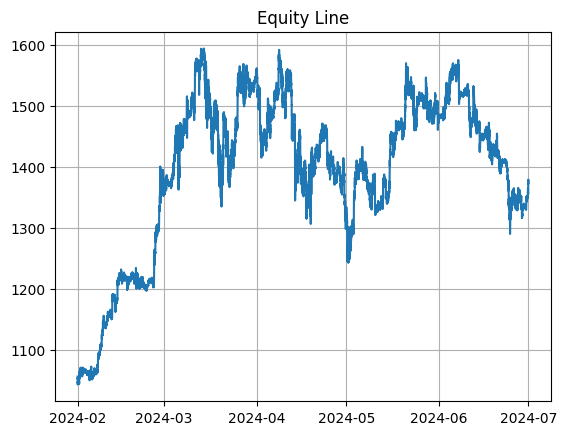

In [14]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni['timestamp'], df_transazioni['valore_totale_portafoglio']);

In [15]:
mdp.calcola_principali_metriche(df_transazioni['valore_totale_portafoglio'], df_transazioni['prezzo'], df_transazioni['bitcoin'])

{'Total Return %': np.float64(30.012210542356637),
 'Max Drawdown': 22.01340777078255,
 'Volatility': np.float64(0.02419427906924589),
 'Sharpe Ratio': np.float64(0.07496556975080734),
 'Sortino Ratio': np.float64(0.1167910627836438),
 'Calmar Ratio': np.float64(1.363360496242229),
 'Profit Factor': np.float64(3018.7211567006966),
 'PnL': np.float64(52.44195471532778)}

In [16]:
df_transazioni[:50]

timestamp    prezzo  prezzo_medio_acquisti_scia   prezzo_TS  \
0  2024-02-01 00:00:00  42609.27                        0.00  42609.2700   
1  2024-02-01 00:05:00  42598.05                        0.00         NaN   
2  2024-02-01 00:10:00  42604.33                    42604.33  46012.6764   
3  2024-02-01 00:15:00  42564.96                    42604.33  46012.6764   
4  2024-02-01 00:20:00  42425.66                    42604.33  46012.6764   
5  2024-02-01 00:25:00  42487.51                    42604.33  46012.6764   
6  2024-02-01 00:30:00  42451.63                    42604.33  46012.6764   
7  2024-02-01 00:35:00  42309.58                    42604.33  46012.6764   
8  2024-02-01 00:40:00  42375.65                    42604.33  46012.6764   
9  2024-02-01 00:45:00  42425.00                    42604.33  46012.6764   
10 2024-02-01 00:50:00  42440.03                    42604.33  46012.6764   
11 2024-02-01 00:55:00  42478.04                    42604.33  46012.6764   
12 2024-02-01 01:00:00  42408.30                    42604.33  46012.6764   
13 2024-02-01 01:05:00  42343.10                    42604.33  46012.6764   
14 2024-02-01 01:10:00  42274.71                    42604.33  46012.6764   
15 2024-02-01 01:15:00  42117.66                    42604.33  46012.6764   
16 2024-02-01 01:20:00  42063.53                    42604.33  46012.6764   
17 2024-02-01 01:25:00  42026.16                    42604.33  46012.6764   
18 2024-02-01 01:30:00  42003.53                    42604.33  46012.6764   
19 2024-02-01 01:35:00  41922.22                    42604.33  46012.6764   
20 2024-02-01 01:40:00  42051.94                    42604.33  46012.6764   
21 2024-02-01 01:45:00  41981.94                    42604.33  46012.6764   
22 2024-02-01 01:50:00  41957.00                    42604.33  46012.6764   
23 2024-02-01 01:55:00  41983.35                    42604.33  46012.6764   
24 2024-02-01 02:00:00  42004.42                    42604.33  46012.6764   
25 2024-02-01 02:05:00  42048.60                    42604.33  46012.6764   
26 2024-02-01 02:10:00  42116.35                    42604.33  46012.6764   
27 2024-02-01 02:15:00  42166.40                    42604.33  46012.6764   
28 2024-02-01 02:20:00  42084.00                    42604.33  46012.6764   
29 2024-02-01 02:25:00  42124.78                    42604.33  46012.6764   
30 2024-02-01 02:30:00  42170.71                    42604.33  46012.6764   
31 2024-02-01 02:35:00  42118.73                    42604.33  46012.6764   
32 2024-02-01 02:40:00  42150.23                    42604.33  46012.6764   
33 2024-02-01 02:45:00  42133.11                    42604.33  46012.6764   
34 2024-02-01 02:50:00  42085.23                    42604.33  46012.6764   
35 2024-02-01 02:55:00  42166.17                    42604.33  46012.6764   
36 2024-02-01 03:00:00  42145.08                    42604.33  46012.6764   
37 2024-02-01 03:05:00  42165.53                    42604.33  46012.6764   
38 2024-02-01 03:10:00  42109.98                    42604.33  46012.6764   
39 2024-02-01 03:15:00  42079.85                    42604.33  46012.6764   
40 2024-02-01 03:20:00  42048.54                    42604.33  46012.6764   
41 2024-02-01 03:25:00  42025.50                    42604.33  46012.6764   
42 2024-02-01 03:30:00  42004.71                    42604.33  46012.6764   
43 2024-02-01 03:35:00  42038.08                    42604.33  46012.6764   
44 2024-02-01 03:40:00  42096.45                    42604.33  46012.6764   
45 2024-02-01 03:45:00  42079.30                    42604.33  46012.6764   
46 2024-02-01 03:50:00  42053.39                    42604.33  46012.6764   
47 2024-02-01 03:55:00  42012.96                    42604.33  46012.6764   
48 2024-02-01 04:00:00  42013.62                    42604.33  46012.6764   
49 2024-02-01 04:05:00  42031.77                    42604.33  46012.6764   

    prezzo_TS_inverso ultima_azione    azione  liquidità_spesa_o_guadagnata  \
0            42609.27             -         -            

In [17]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [18]:
crea_grafico_transazioni(df_transazioni)

### Grafico interattivo temporale

In [19]:
# Funzione per calcolare la dimensione dei pallini
def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

# Aggiungi colonne necessarie per dimensioni pallini
max_quantita_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['liquidità_spesa_o_guadagnata'].max()
max_quantita_acquisto = df_transazioni[df_transazioni['azione'] == 'Acquisto']['liquidità_spesa_o_guadagnata'].max()

df_transazioni['dimensioni_vendite'] = df_transazioni.apply(
    lambda row: calcola_dimensione(row['liquidità_spesa_o_guadagnata'], max_quantita_vendita)
    if row['azione'] == 'Vendita' else 0, axis=1
)
df_transazioni['dimensioni_acquisti'] = df_transazioni.apply(
    lambda row: calcola_dimensione(row['liquidità_spesa_o_guadagnata'], max_quantita_acquisto)
    if row['azione'] == 'Acquisto' else 0, axis=1
)

# App Dash
app = dash.Dash(__name__)

# Layout Dash
app.layout = html.Div([
    html.H1("Grafico Interattivo delle Transazioni"),
    dcc.Graph(id='grafico-transazioni'),
    dcc.Slider(
        id='slider-giorno',
        min=0,
        max=len(df_transazioni) - 1,
        value=0,
        marks={i: str(df_transazioni['timestamp'].iloc[i].date()) for i in range(0, len(df_transazioni), 10)},
        step=1
    ),
    html.Div([
        html.Button("Giorno precedente", id='btn-prev', n_clicks=0),
        html.Button("Giorno successivo", id='btn-next', n_clicks=0),
    ], style={'marginTop': '20px', 'display': 'flex', 'gap': '10px'})
])

# Callback per aggiornare il grafico in base al giorno selezionato
@app.callback(
    Output('grafico-transazioni', 'figure'),
    Input('slider-giorno', 'value')
)
def aggiorna_grafico(giorno):
    # Filtra i dati fino al giorno corrente
    dati_fino_a_giorno = df_transazioni.iloc[:giorno + 1]
    dati_giorno_corrente = df_transazioni.iloc[giorno:giorno + 1]

    # Linea dei prezzi
    trace_prezzo = go.Scatter(
        x=dati_fino_a_giorno['timestamp'],
        y=dati_fino_a_giorno['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2)
    )

    # Pallini per le vendite
    vendite = dati_fino_a_giorno[dati_fino_a_giorno['azione'] == 'Vendita']
    trace_vendite = go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=vendite['dimensioni_vendite'], opacity=0.7)
    )

    # Pallini per gli acquisti
    acquisti = dati_fino_a_giorno[dati_fino_a_giorno['azione'] == 'Acquisto']
    trace_acquisti = go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=acquisti['dimensioni_acquisti'], opacity=0.7)
    )

    # Linea orizzontale per prezzo_TS del giorno corrente
    trace_TS = None
    if pd.notna(dati_giorno_corrente['prezzo_TS'].iloc[0]):
        trace_TS = go.Scatter(
            x=[dati_fino_a_giorno['timestamp'].min(), dati_fino_a_giorno['timestamp'].max()],
            y=[dati_giorno_corrente['prezzo_TS'].iloc[0]] * 2,
            mode='lines',
            name='Prezzo_TS',
            line=dict(color='purple', dash='dash')
        )

    # Linea orizzontale per prezzo_TS_inverso del giorno corrente
    trace_TS_inverso = None
    if pd.notna(dati_giorno_corrente['prezzo_TS_inverso'].iloc[0]):
        trace_TS_inverso = go.Scatter(
            x=[dati_fino_a_giorno['timestamp'].min(), dati_fino_a_giorno['timestamp'].max()],
            y=[dati_giorno_corrente['prezzo_TS_inverso'].iloc[0]] * 2,
            mode='lines',
            name='Prezzo_TS_inverso',
            line=dict(color='orange', dash='dash')
        )

    # Crea la figura
    figure = go.Figure(data=[trace_prezzo, trace_vendite, trace_acquisti])
    if trace_TS:
        figure.add_trace(trace_TS)
    if trace_TS_inverso:
        figure.add_trace(trace_TS_inverso)

    # Configurazione layout
    figure.update_layout(
        title='Grafico Interattivo delle Transazioni',
        xaxis_title=f"Date fino al {dati_giorno_corrente['timestamp'].iloc[0]}",
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white'
    )

    return figure

# Callback per gestire i pulsanti
@app.callback(
    Output('slider-giorno', 'value'),
    [Input('btn-prev', 'n_clicks'),
     Input('btn-next', 'n_clicks')],
    State('slider-giorno', 'value')
)
def aggiorna_slider(btn_prev, btn_next, slider_value):
    ctx = dash.callback_context

    if not ctx.triggered:
        return slider_value

    trigger_id = ctx.triggered[0]['prop_id'].split('.')[0]

    if trigger_id == 'btn-prev':
        return max(slider_value - 1, 0)
    elif trigger_id == 'btn-next':
        return min(slider_value + 1, len(df_transazioni) - 1)

    return slider_value

# Avvia l'app Dash
if __name__ == '__main__':
    app.run_server(debug=True)

# Grid search

In [ ]:
def grid_search(param_grid, condizioni_salto, dati, liquidità_iniziale, bitcoin_iniziali):
    """
    Esegue una grid search sulla funzione strategia_vendita per ottimizzare i parametri variabili.
    
    Parameters:
    - param_grid (dict): Dizionario in cui le chiavi sono i nomi dei parametri e i valori sono liste di valori da testare.
    - dati (pd.DataFrame): DataFrame con i dati storici dei prezzi.
    - liquidità_iniziale (float): Liquidità iniziale in euro.
    - bitcoin_iniziali (float): Quantità iniziale di Bitcoin posseduti.
    
    Returns:
    - dict: Risultato con la miglior combinazione e il miglior fattore di rendimento.
    """
    # Genera tutte le combinazioni di parametri
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    all_combinations = list(product(*param_values))
    n_combinations = len(all_combinations)
    
    # Variabili per tracciare il miglior risultato
    miglior_fattore_rendimento = 0
    miglior_iterazione = None
    miglior_combinazione = None

    # Loop attraverso tutte le combinazioni
    for i, values in enumerate(all_combinations, start=1):
        # Crea un dizionario con la combinazione corrente di parametri
        params = dict(zip(param_names, values))
        
        if not condizioni_salto[i-1]:
            # Esegui la strategia con i parametri correnti
            df_transazioni = trading_doppio_TS(
                dati, liquidità_iniziale, bitcoin_iniziali, **params
            )

            # Calcola il fattore di rendimento
            portafoglio_finale = df_transazioni['valore_totale_portafoglio'].iloc[-1]
            portafoglio_iniziale = liquidità_iniziale + bitcoin_iniziali * dati['Price'].iloc[0]
            fattore_rendimento = portafoglio_finale / portafoglio_iniziale

            # Aggiorna il miglior risultato se il rendimento corrente è superiore
            if fattore_rendimento > miglior_fattore_rendimento:
                miglior_fattore_rendimento = fattore_rendimento
                miglior_iterazione = i
                miglior_combinazione = params

            # Stampa dei risultati dell'iterazione corrente
            print(f"Iterazione {i}/{n_combinations}")
            print(f"  Combinazione testata: {', '.join(f'{k}={v}' for k, v in params.items())}")
            print(f"  Fattore di rendimento: {fattore_rendimento:.4f}")
            print(f"  Miglior fattore di rendimento finora: {miglior_fattore_rendimento:.4f} "
                f"(Iterazione {miglior_iterazione}, Combinazione: {', '.join(f'{k}={v}' for k, v in miglior_combinazione.items())})")
            print("\n")
        else:
            print(f"Saltata combinazione {', '.join(f'{k}={v}' for k, v in params.items())} perchè sarebbe uguale a una già testata\n")

    # Ritorna il miglior risultato
    return {
        "miglior_fattore_rendimento": miglior_fattore_rendimento,
        "miglior_iterazione": miglior_iterazione,
        "miglior_combinazione": miglior_combinazione
    }

In [ ]:
# Esempio di definizione dei parametri per la grid search
param_grid = {
    "perc_primo_acquisto": [0, 0.0005, 0.005, 0.05, 0.5, 1],
    "perc_prima_vendita": [0.108, 0.26, 1],
    "perc_TS": [0, 0.02, 0.036, 0.1],
    "perc_TS_inverso_setting": [0, 0.022, 0.1],
    "A_a": [0, 0.001, 0.01, 2.51],
    "B_a": [0, 1, 3.88, 5],
    "A_v": [0.01, 0.72, 3, 10],
    "B_v":[0, 2.25, 5, 10]
}

param_names = list(param_grid.keys())
param_values = list(param_grid.values())
all_combinations = list(product(*param_values))
n_combinations = len(all_combinations)

condizioni_salto = []
# Loop attraverso tutte le combinazioni
for i, values in enumerate(all_combinations, start=1):
    # Crea un dizionario con la combinazione corrente di parametri
    params = dict(zip(param_names, values))
    condizione = False
    condizioni_salto.append(condizione)

# Esecuzione della grid search
risultato = grid_search(param_grid, condizioni_salto, dati, liquidità_iniziale, bitcoin_iniziali)

# Stampa del miglior risultato
print("Risultato della Grid Search:")
print(f"  Miglior fattore di rendimento: {risultato['miglior_fattore_rendimento']}")
print(f"  Trovato all'iterazione: {risultato['miglior_iterazione']}")
print(f"  Combinazione di parametri ottimale: {', '.join(f'{k}={v}' for k, v in risultato['miglior_combinazione'].items())}")

# 1.6035

# Strategia 2

In [ ]:
def simulate_trailing_strategy(data, trailing_buy, trailing_stop, stop_loss_pct, second_stop_loss_pct, perc_commission_buy, perc_commission_sell, initial_cash, initial_bitcoin, min_buy, min_sell):
    """
    Simula una strategia di trailing stop e trailing buy su un DataFrame contenente i prezzi di bitcoin.

    Args:
        data (pd.DataFrame): DataFrame con almeno due colonne: 'Timestamp' e 'Price'.
        trailing_buy (float): Percentuale di trailing buy (esempio: 0.01 per 1%).
        trailing_stop (float): Percentuale di trailing stop (esempio: 0.02 per 2%).
        stop_loss_pct (float): Percentuale del primo stop loss dopo l'acquisto.
        second_stop_loss_pct (float): Percentuale del secondo stop loss.
        perc_commission_buy (float): Percentuale di commissione sull'acquisto (esempio: 0.001 per 0.1%).
        perc_commission_sell (float): Percentuale di commissione sulla vendita (esempio: 0.001 per 0.1%).
        initial_cash (float): Liquidità iniziale (in USDT).
        initial_bitcoin (float): Quantità iniziale di bitcoin.
        min_buy (float): Prezzo minimo di acquisto in USDT.
        min_sell (float): Prezzo minimo di vendita in USDT.

    Returns:
        pd.DataFrame: DataFrame delle transazioni giornaliere con dettagli.
    """
    # Variabili di supporto
    cash = initial_cash
    bitcoin = initial_bitcoin
    trailing_buy_price = None
    trailing_stop_price = None
    buy_price = None
    lowest_price_since_buy = None # Per gestire il trailing buy
    second_stop_loss = None # Secondo stop loss
    last_action = None # Ultima azione effettiva: "Acquisto" o "Vendita"
    liquidità_spesa_o_guadagnata = 0
    bitcoin_comprati_o_venduti = 0

    transactions = []  # Lista per registrare le transazioni giornaliere

    for i, row in data.iterrows():
        price = row['Price']
        timestamp = row['Timestamp']

        # Effettua eventuali operazioni di acquisto o vendita
        action = "-"  # Azione del giorno, "-" se nessuna azione

        if last_action is None or last_action == "Vendita":
            # Modalità trailing buy
            if trailing_buy_price is None:
                lowest_price_since_buy = price
                trailing_buy_price = price * (1 + trailing_buy)

            lowest_price_since_buy = min(lowest_price_since_buy, price)
            trailing_buy_price = lowest_price_since_buy * (1 + trailing_buy)

            distance_to_trailing = -(price - trailing_buy_price) / trailing_buy_price

            if price >= trailing_buy_price and cash >= min_buy:
                # Effettua l'acquisto
                bitcoin_bought = cash / price * (1 - perc_commission_buy)
                buy_price = price
                trailing_stop_price = buy_price * (1 - trailing_stop)
                stop_loss_price = buy_price * (1 - stop_loss_pct)
                second_stop_loss = None # Verrà impostato solo se il prezzo supererà buy_price / (1 - perc_commission_buy)
                liquidità_spesa_o_guadagnata = cash
                cash = 0
                bitcoin += bitcoin_bought
                last_action = "Acquisto"
                action = "Acquisto"
                bitcoin_comprati_o_venduti = bitcoin_bought

        elif last_action == "Acquisto":
            # Modalità trailing stop
            if price > buy_price / (1 - perc_commission_buy) and second_stop_loss is None:
                second_stop_loss = buy_price / (1 - perc_commission_buy) * (1 - second_stop_loss_pct) + price * second_stop_loss_pct

            if price > trailing_stop_price:
                trailing_stop_price = max(trailing_stop_price or 0, price * (1 - trailing_stop))

            distance_to_trailing = -(price - trailing_stop_price) / trailing_stop_price

            # Controlla se il prezzo scende sotto il massimo tra i livelli di stop
            stop_limit = max(stop_loss_price, trailing_stop_price, second_stop_loss or 0)
            if price <= stop_limit and bitcoin * price >= min_sell:
                # Effettua la vendita
                sell_price = price
                cash += bitcoin * sell_price * (1 - perc_commission_sell)
                bitcoin_comprati_o_venduti = bitcoin
                bitcoin = 0
                last_action = "Vendita"
                if price <= trailing_stop_price:
                    action = "Vendita trailing stop"
                elif not second_stop_loss is None and price <= second_stop_loss:
                    action = 'Vendita second stop loss'
                elif price <= stop_loss_price:
                    action = 'Vendita first stop loss'
                liquidità_spesa_o_guadagnata = cash

                # Resetta variabili dopo la vendita
                trailing_buy_price = None
                trailing_stop_price = None
                buy_price = None
                second_stop_loss = None

        else:
            # Nessuna azione effettuata, calcola la distanza per completezza
            distance_to_trailing = 0

        # Calcola il valore del portafoglio alla fine della giornata
        portfolio_value = cash + bitcoin * price

        # Registra la riga giornaliera
        transactions.append({
            "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action or "-",
            "trailing_buy_price": trailing_buy_price, "trailing_stop_price": trailing_stop_price,
            "distance_to_trailing": distance_to_trailing, 'liquidità_spesa_o_guadagnata': liquidità_spesa_o_guadagnata, 'bitcoin_comprati_o_venduti': bitcoin_comprati_o_venduti, "liquidità": cash, "bitcoin": bitcoin, "valore_totale_portafoglio": portfolio_value
        })

    # Crea un DataFrame dalle transazioni
    transactions_df = pd.DataFrame(transactions)
    return transactions_df

In [ ]:
# Esempio di utilizzo
trailing_buy = 0.02
trailing_stop = 0.02
stop_loss_pct = 0.001
second_stop_loss_pct = 0.01
perc_commission_buy = 0.001 # 0.1% commissione acquisto
perc_commission_sell = 0.001 # 0.1% commissione vendita
initial_cash = 10
initial_bitcoin = 0
min_buy_price = 1 # Prezzo minimo di acquisto
min_sell_price = 1 # Prezzo minimo di vendita

df_transazioni = simulate_trailing_strategy(dati, trailing_buy, trailing_stop, stop_loss_pct, second_stop_loss_pct,
                                             perc_commission_buy, perc_commission_sell, initial_cash, initial_bitcoin,
                                             min_buy_price, min_sell_price)
df_transazioni

timestamp    prezzo    azione ultima_azione  \
0    2021-02-01 00:00:00  32546.27         -             -   
1    2021-02-01 01:00:00  33430.29  Acquisto      Acquisto   
2    2021-02-01 02:00:00  33649.73         -      Acquisto   
3    2021-02-01 03:00:00  33573.97         -      Acquisto   
4    2021-02-01 04:00:00  33558.25         -      Acquisto   
...                  ...       ...       ...           ...   
3589 2021-06-30 20:00:00  34580.40         -       Vendita   
3590 2021-06-30 21:00:00  34806.16         -       Vendita   
3591 2021-06-30 22:00:00  34892.37         -       Vendita   
3592 2021-06-30 23:00:00  35045.00         -       Vendita   
3593 2021-07-01 00:00:00  34727.83         -       Vendita   

      trailing_buy_price  trailing_stop_price  distance_to_trailing  \
0             33197.1954                  NaN              0.019608   
1             33197.1954           32761.6842             -0.007022   
2             33197.1954           32976.7354             -0.020408   
3             33197.1954           32976.7354             -0.018111   
4             33197.1954           32976.7354             -0.017634   
...                  ...                  ...                   ...   
3589          35272.0080                  NaN              0.019608   
3590          35272.0080                  NaN              0.013207   
3591          35272.0080                  NaN              0.010763   
3592          35272.0080                  NaN              0.006436   
3593          35272.0080                  NaN              0.015428   

      liquidità_spesa_o_guadagnata  bitcoin_comprati_o_venduti  liquidità  \
0                         0.000000                    0.000000  10.000000   
1                        10.000000                    0.000299   0.000000   
2                        10.000000                    0.000299   0.000000   
3                        10.000000                    0.000299   0.000000   
4                        10.000000                    0.000299   0.000000   
...                            ...                         ...        ...   
3589                     10.029439                    0.000289  10.029439   
3590                     10.029439                    0.000289  10.029439   
3591                     10.029439                    0.000289  10.029439   
3592                     10.029439                    0.000289  10.029439   
3593                     10.029439                    0.000289  10.029439   

       bitcoin  valore_totale_portafoglio  
0     0.000000                  10.000000  
1     0.000299                   9.990000  
2     0.000299                  10.055575  
3     0.000299                  10.032936  
4     0.000299                  10.028238  
...        ...                        ...  
3589  0.000000                  10.029439  
3590  0.000000                  10.029439  
3591  0.000000                  10.029439  
3592  0.000000                  10.029439  
3593  0.000000                  10.029439  

[3594 rows x 12 columns]

In [ ]:
df_transazioni['azione'].value_counts()

azione
-                           3224
Acquisto                     185
Vendita first stop loss       79
Vendita trailing stop         53
Vendita second stop loss      53
Name: count, dtype: int64

In [ ]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(1.0029439233771562)

In [ ]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni_2(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[(df_transazioni['azione'] == 'Vendita first stop loss') | (df_transazioni['azione'] == 'Vendita second stop loss') | (df_transazioni['azione'] == 'Vendita trailing stop')]
    acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [ ]:
crea_grafico_transazioni_2(df_transazioni)

# Strategia 3

In [ ]:
# Funzione per determinare quanto acquistare
def quanto_acquistare(price, first_buy_price, ultimo_acquisto_speso, cash):
    variazione_primo = abs((price - first_buy_price) / first_buy_price)
    return min(ultimo_acquisto_speso + variazione_primo * cash, cash)

In [ ]:
def simulate_trailing_strategy(data, trailing_buy_pct, trailing_stop_pct, stop_loss_pct, second_stop_loss_pct, perc_commission_buy, perc_commission_sell, first_buy_pct, initial_cash, initial_bitcoin, min_buy_price, min_sell_price):
    """
    Simula una strategia di trailing stop e trailing buy su un DataFrame contenente i prezzi di bitcoin.

    Args:
        data (pd.DataFrame): DataFrame con almeno due colonne: 'Timestamp' e 'Price'.
        trailing_buy (float): Percentuale di trailing buy (esempio: 0.01 per 1%).
        trailing_stop_pct (float): Percentuale di trailing stop (esempio: 0.02 per 2%).
        stop_loss_pct (float): Percentuale del primo stop loss dopo ogni acquisto.
        second_stop_loss_pct (float): Percentuale del secondo stop loss.
        perc_commission_buy (float): Percentuale di commissione sull'acquisto (esempio: 0.001 per 0.1%).
        perc_commission_sell (float): Percentuale di commissione sulla vendita (esempio: 0.001 per 0.1%).
        first_buy_pct (float): Percentuale della liquidità da usare per il primo acquisto di ogni ciclo.
        initial_cash (float): Liquidità iniziale (in USDT).
        initial_bitcoin (float): Quantità iniziale di bitcoin.
        min_buy_price (float): Prezzo minimo di acquisto in USDT.
        min_sell_price (float): Prezzo minimo di vendita in USDT.

    Returns:
        pd.DataFrame: DataFrame delle transazioni giornaliere con dettagli.
    """
    # Variabili di supporto
    cash = initial_cash
    bitcoin = initial_bitcoin
    trailing_buy_price = None
    trailing_stop_price = None
    fake_stop_loss_price = None
    second_stop_loss = None
    prezzo_medio_pesato_acquisti = None
    ultimo_acquisto_speso = 0  # Liquidità spesa per l'ultimo acquisto
    spesa_totale = 0
    first_buy_price = None
    last_action = None  # Ultima azione effettiva: "Acquisto" o "Vendita"

    transactions = []  # Lista per registrare le transazioni giornaliere

    for i, row in data.iterrows():
        price = row['Price']
        timestamp = row['Timestamp']

        # Variabili per liquidità spesa o guadagnata e bitcoin comprati o venduti
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0

        # Azione del giorno, "-" se nessuna azione
        action = "-"

        if last_action is None or last_action == "Vendita":
            # Modalità trailing buy
            if trailing_buy_price is None:
                trailing_buy_price = price * (1 + trailing_buy_pct)

            if price >= trailing_buy_price and cash * first_buy_pct >= min_buy_price:
                # Effettua il primo acquisto del ciclo
                liquidità_da_usare = cash * first_buy_pct
                bitcoin_bought = liquidità_da_usare / price * (1 - perc_commission_buy)
                bitcoin += bitcoin_bought
                liquidità_spesa_o_guadagnata = liquidità_da_usare
                cash -= liquidità_da_usare
                prezzo_medio_pesato_acquisti = price
                ultimo_acquisto_speso = liquidità_da_usare
                spesa_totale = liquidità_da_usare
                first_buy_price = price
                fake_stop_loss_price = price * (1 - stop_loss_pct)
                # trailing_stop_price = price * (1 - trailing_stop_pct)
                second_stop_loss = None
                last_action = "Acquisto"
                action = "Primo acquisto"

        elif last_action == "Acquisto":
            # Aggiornamenti legati al secondo stop loss e trailing stop
            if price > prezzo_medio_pesato_acquisti / (1 - perc_commission_buy):
                second_stop_loss = ((1 - second_stop_loss_pct) * prezzo_medio_pesato_acquisti / (1 - perc_commission_buy) + second_stop_loss_pct * price)
                trailing_stop_price = price * (1 - trailing_stop_pct)

            # Controlla il primo stop loss
            if price <= fake_stop_loss_price:
                liquidità_da_usare = quanto_acquistare(price, first_buy_price, ultimo_acquisto_speso, cash)
                if liquidità_da_usare >= min_buy_price:
                    bitcoin_bought = liquidità_da_usare / price * (1 - perc_commission_buy)
                    bitcoin += bitcoin_bought
                    liquidità_spesa_o_guadagnata = liquidità_da_usare
                    cash -= liquidità_da_usare
                    spesa_totale += liquidità_da_usare
                    prezzo_medio_pesato_acquisti = (prezzo_medio_pesato_acquisti * (spesa_totale - liquidità_da_usare) + price * liquidità_da_usare) / spesa_totale
                    ultimo_acquisto_speso = liquidità_da_usare
                    fake_stop_loss_price = price * (1 - stop_loss_pct)
                    action = "Acquisto"

            # Controlla il secondo stop loss o il trailing stop per vendere
            elif (price <= second_stop_loss or price <= trailing_stop_price) and bitcoin * price >= min_sell_price:
                liquidità_spesa_o_guadagnata = bitcoin * price * (1 - perc_commission_sell)
                cash += liquidità_spesa_o_guadagnata
                bitcoin_comprati_o_venduti = bitcoin
                bitcoin = 0
                last_action = "Vendita"
                action = "Vendita"
                trailing_buy_price = None
                fake_stop_loss_price = None
                trailing_stop_price = None
                second_stop_loss = None

        # Calcola il valore del portafoglio alla fine della giornata
        portfolio_value = cash + bitcoin * price

        # Registra la riga giornaliera
        transactions.append({
            "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action or "-",
            "Trailing_buy_Price": trailing_buy_price, "Trailing_Stop_Price": trailing_stop_price,
            "Fake_Stop_Loss_Price": fake_stop_loss_price, "Second_Stop_Loss": second_stop_loss,
            "Prezzo_Medio_Pesato_Acquisti": prezzo_medio_pesato_acquisti, "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "liquidità": cash, "bitcoin": bitcoin,
            "valore_totale_portafoglio": portfolio_value
        })

    # Crea un DataFrame dalle transazioni
    transactions_df = pd.DataFrame(transactions)
    return transactions_df

In [ ]:
# Esempio di utilizzo
trailing_buy_pct = 0.02
trailing_stop_pct = 0.02
stop_loss_pct = 0.05
second_stop_loss_pct = 0.01
perc_commission_buy = 0.001 # 0.1% commissione acquisto
perc_commission_sell = 0.001 # 0.1% commissione vendita
first_buy_pct = 0.01
initial_cash = 100
initial_bitcoin = 0
min_buy_price = 1 # Prezzo minimo di acquisto
min_sell_price = 1 # Prezzo minimo di vendita

df_transazioni = simulate_trailing_strategy(dati, trailing_buy_pct, trailing_stop_pct, stop_loss_pct, second_stop_loss_pct,
                                             perc_commission_buy, perc_commission_sell, first_buy_pct, initial_cash, initial_bitcoin,
                                             min_buy_price, min_sell_price)
df_transazioni

timestamp        prezzo          azione ultima_azione  \
0   2021-02-01  27790.582031               -             -   
1   2021-02-02  29501.521484  Primo acquisto      Acquisto   
2   2021-02-03  31119.447266               -      Acquisto   
3   2021-02-04  30859.554688               -      Acquisto   
4   2021-02-05  31658.248047               -      Acquisto   
..         ...           ...             ...           ...   
146 2021-06-27  29013.742188               -       Vendita   
147 2021-06-28  28866.302734               -       Vendita   
148 2021-06-29  30139.980469               -       Vendita   
149 2021-06-30  29555.054688               -       Vendita   
150 2021-07-01  28341.414062               -       Vendita   

     Trailing_buy_Price  Trailing_Stop_Price  Fake_Stop_Loss_Price  \
0          28346.393672                  NaN                   NaN   
1          28346.393672                  NaN           28026.44541   
2          28346.393672         30497.058320           28026.44541   
3          28346.393672         30242.363594           28026.44541   
4          28346.393672         31025.083086           28026.44541   
..                  ...                  ...                   ...   
146        31277.817891                  NaN                   NaN   
147        31277.817891                  NaN                   NaN   
148        31277.817891                  NaN                   NaN   
149        31277.817891                  NaN                   NaN   
150        31277.817891                  NaN                   NaN   

     Second_Stop_Loss  Prezzo_Medio_Pesato_Acquisti  \
0                 NaN                           NaN   
1                 NaN                  29501.521484   
2        29546.936484                  29501.521484   
3        29544.337558                  29501.521484   
4        29552.324492                  29501.521484   
..                ...                           ...   
146               NaN                  27546.242480   
147               NaN                  27546.242480   
148               NaN                  27546.242480   
149               NaN                  27546.242480   
150               NaN                  27546.242480   

     liquidità_spesa_o_guadagnata  bitcoin_comprati_o_venduti   liquidità  \
0                             0.0                         0.0  100.000000   
1                             1.0                         0.0   99.000000   
2                             0.0                         0.0   99.000000   
3                             0.0                         0.0   99.000000   
4                             0.0                         0.0   99.000000   
..                            ...                         ...         ...   
146                           0.0                         0.0   99.629814   
147                           0.0                         0.0   99.629814   
148                           0.0                         0.0   99.629814   
149                           0.0                         0.0   99.629814   
150                           0.0                         0.0   99.629814   

      bitcoin  valore_totale_portafoglio  
0    0.000000                 100.000000  
1    0.000034                  99.999000  
2    0.000034                 100.053787  
3    0.000034                 100.044987  
4    0.000034                 100.072032  
..        ...                        ...  
146  0.000000                  99.629814  
147  0.000000                  99.629814  
148  0.000000                  99.629814  
149  0.000000                  99.629814  
150  0.000000                  99.629814  

[151 rows x 14 columns]

In [ ]:
df_transazioni['azione'].value_counts()

azione
-                 148
Primo acquisto      1
Acquisto            1
Vendita             1
Name: count, dtype: int64

In [ ]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(0.9962981436231505)

In [ ]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni_2(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [ ]:
crea_grafico_transazioni_2(df_transazioni)

# Strategia 4 (acquisti dal secondo in poi con fake_stop_loss e trailing buy)

In [ ]:
def mappatura_variazione_acquisti(variazione_perc, A_a, B_a):
    return variazione_perc ** A_a / (B_a + (1 - B_a) * variazione_perc ** A_a)

# Funzione per determinare quanto acquistare
def quanto_acquistare(price, first_buy_price, last_buy_purchase, cash, do_buy, A_a, B_a):
    variazione_primo = abs((price - first_buy_price) / first_buy_price)
    variazione_mappata = mappatura_variazione_acquisti(variazione_primo, A_a, B_a)
    if do_buy:
        return min(last_buy_purchase + variazione_mappata * cash, cash)
    elif last_buy_purchase + variazione_mappata * cash > cash:
        return 0
    else:
        return last_buy_purchase + variazione_mappata * cash

In [ ]:
def trading_doppio_TS_4(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
                              trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy, A_a, B_a):
    # Variabili iniziali
    cash = initial_cash
    bitcoin = initial_bitcoin
    last_action = None
    prezzo_medio_pesato_acquisti = 0
    spesa_totale = 0
    trailing_buy_price = None
    fake_stop_loss_price = None
    trailing_stop_price = None
    transactions = []

    for idx, row in dati.iterrows():
        timestamp = row['Timestamp']
        price = row['Price']
        action = "-"
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0
        
        # Se l'ultima azione è None o Vendita, dobbiamo impostare un trailing buy per iniziare un nuovo ciclo
        if last_action in [None, "Vendita"]:
            if trailing_buy_price is None:
                trailing_buy_price = price * (1 + trailing_buy_pct)
            else:
                trailing_buy_price = min(trailing_buy_price, price * (1 + trailing_buy_pct))
            if price >= trailing_buy_price:
                # Acquista con la percentuale first_buy_pct della liquidità disponibile
                spesa = cash * first_buy_pct
                if spesa >= min_buy:
                    bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
                    cash -= spesa
                    bitcoin += bitcoin_acquistati
                    prezzo_medio_pesato_acquisti = price
                    spesa_totale = spesa
                    first_buy_price = price
                    last_buy_purchase = spesa
                    fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
                    # trailing_buy_price = None
                    action = "Primo acquisto"
                    liquidità_spesa_o_guadagnata = spesa
                    bitcoin_comprati_o_venduti = bitcoin_acquistati
                    last_action = "Acquisto"
        
        # Se l'ultima azione è Acquisto, valuta ulteriori acquisti o vendi
        elif last_action == "Acquisto":
            if price <= fake_stop_loss_price:
                # Acquisto successivo se il prezzo scende sotto il fake_stop_loss
                spesa = quanto_acquistare(price, first_buy_price, last_buy_purchase, cash, do_buy, A_a, B_a)
                if spesa >= min_buy:
                    bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
                    cash -= spesa
                    last_buy_purchase = spesa
                    bitcoin += bitcoin_acquistati
                    prezzo_medio_pesato_acquisti = (
                        prezzo_medio_pesato_acquisti * spesa_totale + price * spesa
                    ) / (spesa_totale + spesa)
                    spesa_totale += spesa
                    fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
                    action = "Acquisto"
                    liquidità_spesa_o_guadagnata = spesa
                    bitcoin_comprati_o_venduti = bitcoin_acquistati
            elif price > prezzo_medio_pesato_acquisti / ((1 - commission_buy_pct) * (1 - trailing_sell_pct)):
                # Imposta un trailing sell
                if trailing_stop_price is None:
                    trailing_stop_price = price * (1 - trailing_sell_pct)
                else:
                    trailing_stop_price = max(trailing_stop_price, price * (1 - trailing_sell_pct))
                if price <= trailing_stop_price:
                    # Vendi tutti i bitcoin posseduti
                    ricavato = bitcoin * price * (1 - commission_sell_pct)
                    if ricavato >= min_sell:
                        cash += ricavato
                        liquidità_spesa_o_guadagnata = ricavato
                        bitcoin_comprati_o_venduti = bitcoin
                        bitcoin = 0
                        spesa_totale = 0
                        prezzo_medio_pesato_acquisti = 0
                        trailing_buy_price = None
                        trailing_stop_price = None
                        fake_stop_loss_price = None
                        action = "Vendita"
                        last_action = "Vendita"

        # Valore totale del portafoglio
        portfolio_value = cash + bitcoin * price

        # Aggiungi la transazione
        transactions.append({
            "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action,
            "trailing_buy_price": trailing_buy_price, "trailing_stop_price": trailing_stop_price,
            "fake_stop_loss_price": fake_stop_loss_price, "prezzo_medio_pesato_acquisti": prezzo_medio_pesato_acquisti,
            "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "liquidità": cash, "bitcoin": bitcoin,
            "valore_totale_portafoglio": portfolio_value
        })

    # Restituisci il dataframe delle transazioni
    return pd.DataFrame(transactions)

In [ ]:
initial_cash = 1000
initial_bitcoin = 0
commission_buy_pct = 0.001 # 0.1% commissione acquisto
commission_sell_pct = 0.001 # 0.1% commissione vendita
min_buy = 5 # Prezzo minimo di acquisto
min_sell = 5 # Prezzo minimo di vendita
trailing_buy_pct = 0.01
first_buy_pct = 0.01
fake_stop_loss_pct = 0.01
trailing_sell_pct = 0.001
do_buy = True # Sarebbe il compra_pure, che se è True e l'acquisto è superiore alla liquidità disponibile, usa tutta la liquidità, altrimenti non fa niente
A_a = 10
B_a = 10

df_transazioni = trading_doppio_TS_4(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
                              trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy, A_a, B_a)
df_transazioni

timestamp        prezzo          azione ultima_azione  \
0   2021-02-01  27790.582031               -          None   
1   2021-02-02  29501.521484  Primo acquisto      Acquisto   
2   2021-02-03  31119.447266               -      Acquisto   
3   2021-02-04  30859.554688         Vendita       Vendita   
4   2021-02-05  31658.248047               -       Vendita   
..         ...           ...             ...           ...   
146 2021-06-27  29013.742188               -      Acquisto   
147 2021-06-28  28866.302734               -      Acquisto   
148 2021-06-29  30139.980469               -      Acquisto   
149 2021-06-30  29555.054688               -      Acquisto   
150 2021-07-01  28341.414062               -      Acquisto   

     trailing_buy_price  trailing_stop_price  fake_stop_loss_price  \
0          28068.487852                  NaN                   NaN   
1          28068.487852                  NaN          29206.506270   
2          28068.487852         31088.327818          29206.506270   
3                   NaN                  NaN                   NaN   
4          31974.830527                  NaN                   NaN   
..                  ...                  ...                   ...   
146        47627.062891                  NaN          26325.153809   
147        47627.062891                  NaN          26325.153809   
148        47627.062891                  NaN          26325.153809   
149        47627.062891                  NaN          26325.153809   
150        47627.062891                  NaN          26325.153809   

     prezzo_medio_pesato_acquisti  liquidità_spesa_o_guadagnata  \
0                        0.000000                      0.000000   
1                    29501.521484                     10.000000   
2                    29501.521484                      0.000000   
3                        0.000000                     10.439416   
4                        0.000000                      0.000000   
..                            ...                           ...   
146                  36842.023773                      0.000000   
147                  36842.023773                      0.000000   
148                  36842.023773                      0.000000   
149                  36842.023773                      0.000000   
150                  36842.023773                      0.000000   

     bitcoin_comprati_o_venduti    liquidità   bitcoin  \
0                      0.000000  1000.000000  0.000000   
1                      0.000339   990.000000  0.000339   
2                      0.000000   990.000000  0.000339   
3                      0.000339  1000.439416  0.000000   
4                      0.000000  1000.439416  0.000000   
..                          ...          ...       ...   
146                    0.000000   908.785569  0.003189   
147                    0.000000   908.785569  0.003189   
148                    0.000000   908.785569  0.003189   
149                    0.000000   908.785569  0.003189   
150                    0.000000   908.785569  0.003189   

     valore_totale_portafoglio  
0                  1000.000000  
1                   999.990000  
2                  1000.537873  
3                  1000.439416  
4                  1000.439416  
..                         ...  
146                1001.317304  
147                1000.847085  
148                1004.909146  
149                1003.043679  
150                 999.173090  

[151 rows x 13 columns]

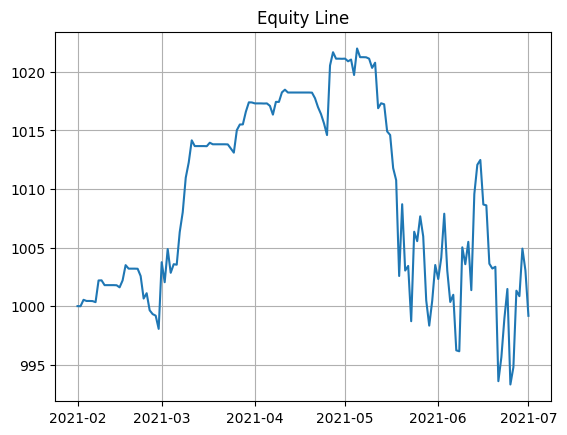

In [ ]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni['timestamp'], df_transazioni['valore_totale_portafoglio']);

In [ ]:
df_transazioni['azione'].value_counts()

azione
-                 105
Acquisto           27
Primo acquisto     10
Vendita             9
Name: count, dtype: int64

In [ ]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(0.9991730897608748)

In [ ]:
indice_ultima_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['timestamp'].idxmax() if "Vendita" in df_transazioni['azione'].unique() else None
indice_ultima_vendita

np.int64(94)

In [ ]:
if indice_ultima_vendita is not None:
    df_transazioni_tagliato_ad_ultima_vendita = df_transazioni[:indice_ultima_vendita+1]
    display(df_transazioni_tagliato_ad_ultima_vendita)

timestamp        prezzo          azione ultima_azione  trailing_buy_price  \
0  2021-02-01  27790.582031               -          None        28068.487852   
1  2021-02-02  29501.521484  Primo acquisto      Acquisto        28068.487852   
2  2021-02-03  31119.447266               -      Acquisto        28068.487852   
3  2021-02-04  30859.554688         Vendita       Vendita                 NaN   
4  2021-02-05  31658.248047               -       Vendita        31974.830527   
..        ...           ...             ...           ...                 ...   
90 2021-05-02  47088.570312        Acquisto      Acquisto        44612.678437   
91 2021-05-03  47432.769531               -      Acquisto        44612.678437   
92 2021-05-04  44387.261719        Acquisto      Acquisto        44612.678437   
93 2021-05-05  47823.058594               -      Acquisto        44612.678437   
94 2021-05-06  46742.558594         Vendita       Vendita                 NaN   

    trailing_stop_price  fake_stop_loss_price  prezzo_medio_pesato_acquisti  \
0                   NaN                   NaN                      0.000000   
1                   NaN          29206.506270                  29501.521484   
2          31088.327818          29206.506270                  29501.521484   
3                   NaN                   NaN                      0.000000   
4                   NaN                   NaN                      0.000000   
..                  ...                   ...                           ...   
90                  NaN          46617.684609                  47567.810547   
91                  NaN          46617.684609                  47567.810547   
92                  NaN          43943.389102                  46507.627604   
93         47775.235535          43943.389102                  46507.627604   
94                  NaN                   NaN                      0.000000   

    liquidità_spesa_o_guadagnata  bitcoin_comprati_o_venduti    liquidità  \
0                       0.000000                    0.000000  1000.000000   
1                      10.000000                    0.000339   990.000000   
2                       0.000000                    0.000000   990.000000   
3                      10.439416                    0.000339  1000.439416   
4                       0.000000                    0.000000  1000.439416   
..                           ...                         ...          ...   
90                     10.211259                    0.000217  1000.703368   
91                      0.000000                    0.000000  1000.703368   
92                     10.211259                    0.000230   990.492109   
93                      0.000000                    0.000000   990.492109   
94                     30.761723                    0.000659  1021.253832   

     bitcoin  valore_totale_portafoglio  
0   0.000000                1000.000000  
1   0.000339                 999.990000  
2   0.000339                1000.537873  
3   0.000000                1000.439416  
4   0.000000                1000.439416  
..       ...                        ...  
90  0.000429                1020.901965  
91  0.000429                1021.049609  
92  0.000659                1019.733030  
93  0.000659                1021.996424  
94  0.000000                1021.253832  

[95 rows x 13 columns]

In [ ]:
if indice_ultima_vendita is not None:
    print(df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[-1] / df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[0])

1.0212538323404743


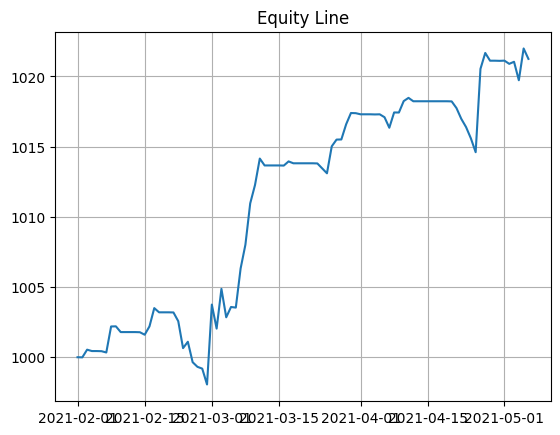

In [ ]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni_tagliato_ad_ultima_vendita['timestamp'], df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio']);

In [ ]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni_2(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [ ]:
crea_grafico_transazioni_2(df_transazioni)

In [ ]:
if indice_ultima_vendita is not None:
    crea_grafico_transazioni_2(df_transazioni_tagliato_ad_ultima_vendita)

C:\Users\alessandro.imbriaco\AppData\Local\Temp\ipykernel_9292\1841209342.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alessandro.imbriaco\AppData\Local\Temp\ipykernel_9292\1841209342.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Strategia 5 (tutti gli acquisti con trailing buy)

In [ ]:
# # Funzione per determinare quanto acquistare
# def quanto_acquistare(price, first_buy_price, ultimo_acquisto_speso, cash, do_buy):
#     variazione_primo = abs((price - first_buy_price) / first_buy_price)
#     if do_buy:
#         return min(ultimo_acquisto_speso + variazione_primo * cash, cash)
#     elif ultimo_acquisto_speso + variazione_primo * cash > cash:
#         return 0
#     else:
#         return ultimo_acquisto_speso + variazione_primo * cash

In [ ]:
# def simulate_trailing_strategy(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
#                               trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy):
#     # Variabili iniziali
#     cash = initial_cash
#     bitcoin = initial_bitcoin
#     last_action = None
#     prezzo_medio_pesato_acquisti = 0
#     spesa_totale = 0
#     trailing_buy_price = None
#     fake_stop_loss_price = None
#     trailing_stop_price = None
#     transactions = []

#     for idx, row in dati.iterrows():
#         timestamp = row['Timestamp']
#         price = row['Price']
#         action = "-"
#         liquidità_spesa_o_guadagnata = 0
#         bitcoin_comprati_o_venduti = 0
        
#         # Se l'ultima azione è None o Vendita, dobbiamo impostare un trailing buy per iniziare un nuovo ciclo
#         if last_action in [None, "Vendita"]:
#             if trailing_buy_price is None:
#                 trailing_buy_price = price * (1 + trailing_buy_pct)
#             else:
#                 trailing_buy_price = min(trailing_buy_price, price * (1 + trailing_buy_pct))
#             if price >= trailing_buy_price:
#                 # Acquista con la percentuale first_buy_pct della liquidità disponibile
#                 spesa = cash * first_buy_pct
#                 if spesa >= min_buy:
#                     bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
#                     cash -= spesa
#                     bitcoin += bitcoin_acquistati
#                     prezzo_medio_pesato_acquisti = price
#                     spesa_totale = spesa
#                     fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
#                     # trailing_buy_price = None
#                     action = "Primo acquisto"
#                     liquidità_spesa_o_guadagnata = spesa
#                     bitcoin_comprati_o_venduti = bitcoin_acquistati
#                     last_action = "Acquisto"
        
#         # Se l'ultima azione è Acquisto, valuta ulteriori acquisti o vendi
#         elif last_action == "Acquisto":
#             if price <= fake_stop_loss_price:
#                 # Acquisto successivo se il prezzo scende sotto il fake_stop_loss
#                 spesa = quanto_acquistare(price, prezzo_medio_pesato_acquisti, spesa_totale, cash, do_buy)
#                 if spesa >= min_buy:
#                     bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
#                     cash -= spesa
#                     bitcoin += bitcoin_acquistati
#                     prezzo_medio_pesato_acquisti = (
#                         prezzo_medio_pesato_acquisti * spesa_totale + price * spesa
#                     ) / (spesa_totale + spesa)
#                     spesa_totale += spesa
#                     fake_stop_loss_price = price * (1 - fake_stop_loss_pct)
#                     action = "Acquisto"
#                     liquidità_spesa_o_guadagnata = spesa
#                     bitcoin_comprati_o_venduti = bitcoin_acquistati
#             elif price > prezzo_medio_pesato_acquisti / ((1 - commission_buy_pct) * (1 - trailing_sell_pct)):
#                 # Imposta un trailing sell
#                 if trailing_stop_price is None:
#                     trailing_stop_price = price * (1 - trailing_sell_pct)
#                 else:
#                     trailing_stop_price = max(trailing_stop_price, price * (1 - trailing_sell_pct))
#                 if price <= trailing_stop_price:
#                     # Vendi tutti i bitcoin posseduti
#                     ricavato = bitcoin * price * (1 - commission_sell_pct)
#                     if ricavato >= min_sell:
#                         cash += ricavato
#                         liquidità_spesa_o_guadagnata = ricavato
#                         bitcoin_comprati_o_venduti = bitcoin
#                         bitcoin = 0
#                         spesa_totale = 0
#                         prezzo_medio_pesato_acquisti = 0
#                         trailing_buy_price = None
#                         trailing_stop_price = None
#                         fake_stop_loss_price = None
#                         action = "Vendita"
#                         last_action = "Vendita"

#         # Valore totale del portafoglio
#         portfolio_value = cash + bitcoin * price

#         # Aggiungi la transazione
#         transactions.append({
#             "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action,
#             "trailing_buy_price": trailing_buy_price, "trailing_stop_price": trailing_stop_price,
#             "fake_stop_loss_price": fake_stop_loss_price, "prezzo_medio_pesato_acquisti": prezzo_medio_pesato_acquisti,
#             "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
#             "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "liquidità": cash, "bitcoin": bitcoin,
#             "valore_totale_portafoglio": portfolio_value
#         })

#     # Restituisci il dataframe delle transazioni
#     return pd.DataFrame(transactions)

In [ ]:
# # Esempio di utilizzo
# initial_cash = 100
# initial_bitcoin = 0
# commission_buy_pct = 0.001 # 0.1% commissione acquisto
# commission_sell_pct = 0.001 # 0.1% commissione vendita
# min_buy = 5 # Prezzo minimo di acquisto
# min_sell = 5 # Prezzo minimo di vendita
# trailing_buy_pct = 0.02
# first_buy_pct = 0.1
# fake_stop_loss_pct = 0.05
# trailing_sell_pct = 0.02
# do_buy = False

# df_transazioni = simulate_trailing_strategy(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell,
#                               trailing_buy_pct, first_buy_pct, fake_stop_loss_pct, trailing_sell_pct, do_buy)
# df_transazioni

In [ ]:
# df_transazioni['azione'].value_counts()

In [ ]:
# df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

In [ ]:
# indice_ultima_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['timestamp'].idxmax() if "Vendita" in df_transazioni['azione'].unique() else None
# indice_ultima_vendita

In [ ]:
# if indice_ultima_vendita is not None:
#     df_transazioni_tagliato_ad_ultima_vendita = df_transazioni[:indice_ultima_vendita+1]
#     display(df_transazioni_tagliato_ad_ultima_vendita)

In [ ]:
# if indice_ultima_vendita is not None:
#     print(df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[-1] / df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[0])

In [ ]:
# # Funzione per creare il grafico delle transazioni
# def crea_grafico_transazioni_2(df_transazioni):
#     # Gestione NaN per sicurezza
#     df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
#     df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

#     # Filtra solo le transazioni di vendita e acquisto
#     vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
#     acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

#     # Calcolo della dimensione dei punti per le vendite e gli acquisti
#     max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
#     max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

#     def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
#         return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

#     # Applica la funzione di dimensione per ogni punto vendita e acquisto
#     dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
#     dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

#     # Funzione per creare una stringa di hover con tutte le colonne
#     def crea_hover_text(df):
#         hover_texts = []
#         for _, row in df.iterrows():
#             hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
#             hover_texts.append(hover_text)
#         return hover_texts

#     # Creazione del grafico
#     fig = go.Figure()

#     # Linea dell'andamento dei prezzi
#     fig.add_trace(go.Scatter(
#         x=df_transazioni['timestamp'],
#         y=df_transazioni['prezzo'],
#         mode='lines',
#         name='Prezzi Bitcoin',
#         line=dict(color='blue', width=2),
#         hoverinfo='x+y'
#     ))

#     # Scatter plot per le vendite
#     fig.add_trace(go.Scatter(
#         x=vendite['timestamp'],
#         y=vendite['prezzo'],
#         mode='markers',
#         name='Vendite',
#         marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
#         text=crea_hover_text(vendite),
#         hoverinfo='text'
#     ))

#     # Scatter plot per gli acquisti
#     fig.add_trace(go.Scatter(
#         x=acquisti['timestamp'],
#         y=acquisti['prezzo'],
#         mode='markers',
#         name='Acquisti',
#         marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
#         text=crea_hover_text(acquisti),
#         hoverinfo='text'
#     ))

#     # Configurazione del layout
#     fig.update_layout(
#         title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
#         xaxis_title='Data',
#         yaxis_title='Prezzo (€)',
#         hovermode='closest',
#         template='plotly_white',
#         legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
#         width=1200,
#         height=800,
#         xaxis=dict(
#             rangeslider=dict(visible=True),  # Abilita il range slider
#             type="date"  # Imposta l'asse x come asse temporale
#         )
#     )

#     # Mostra il grafico
#     fig.show()

In [ ]:
# crea_grafico_transazioni_2(df_transazioni)

In [ ]:
# if indice_ultima_vendita is not None:
#     crea_grafico_transazioni_2(df_transazioni_tagliato_ad_ultima_vendita)

# Strategia 6 (tutti gli acquisti spot)

In [344]:
def mappatura_variazione_acquisti(variazione_perc, A_a, B_a):
    return variazione_perc ** A_a / (B_a + (1 - B_a) * variazione_perc ** A_a)

# Funzione per determinare quanto acquistare
def quanto_acquistare(price, first_buy_price, last_buy_purchase, cash, do_buy, A_a, B_a):
    variazione_primo = abs((price - first_buy_price) / first_buy_price)
    variazione_mappata = mappatura_variazione_acquisti(variazione_primo, A_a, B_a)
    if do_buy:
        return min(last_buy_purchase + variazione_mappata * cash, cash)
    elif last_buy_purchase + variazione_mappata * cash > cash:
        return 0
    else:
        return last_buy_purchase + variazione_mappata * cash

In [345]:
def trading_doppio_TS_6(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell, first_buy_pct, do_buy, min_earn_pct, buy_only_under_last_price, A_a, B_a):
    """
    Simula una strategia semplice di acquisti e vendite a mercato.

    Args:
        dati (pd.DataFrame): DataFrame con almeno due colonne: 'Timestamp' e 'Price'.
        initial_cash (float): Liquidità iniziale (in USDT).
        initial_bitcoin (float): Quantità iniziale di bitcoin.
        commission_buy_pct (float): Percentuale di commissione sull'acquisto (esempio: 0.001 per 0.1%).
        commission_sell_pct (float): Percentuale di commissione sulla vendita (esempio: 0.001 per 0.1%).
        min_buy (float): Quantità minima in USDT per effettuare un acquisto.
        min_sell (float): Quantità minima in USDT per effettuare una vendita.
        first_buy_pct (float): Percentuale della liquidità da usare per il primo acquisto di ogni ciclo.
        do_buy (bool): Se True, usa tutta la liquidità quando è richiesta più liquidità di quella posseduta, altrimenti non acquista niente.
        min_earn_pct (float): Percentuale di guadagno minimo che si desidera tra vendita e prezzo medio pesato degli acquisti.
        A_a (float): Parametro per la funzione di mappatura della variazione.
        B_a (float): Parametro per la funzione di mappatura della variazione.

    Returns:
        pd.DataFrame: DataFrame delle transazioni giornaliere con dettagli.
    """

    # Variabili di supporto
    cash = initial_cash
    bitcoin = initial_bitcoin
    prezzo_medio_pesato_acquisti = None
    # last_buy_purchase = 0  # Liquidità spesa per l'ultimo acquisto
    # total_purchase = 0
    # first_buy_price = None
    last_action = None  # Ultima azione effettiva: "Acquisto" o "Vendita"

    transactions = []  # Lista per registrare le transazioni giornaliere

    for i, row in dati.iterrows():
        price = row['Price']
        timestamp = row['Timestamp']

        # Variabili per liquidità spesa o guadagnata e bitcoin comprati o venduti
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0

        # Azione del giorno, "-" se nessuna azione
        action = "-"

        if last_action is None or last_action == "Vendita":
            # Primo acquisto del ciclo
            liquidità_da_usare = cash * first_buy_pct
            if liquidità_da_usare >= min_buy:
                bitcoin_bought = liquidità_da_usare / price * (1 - commission_buy_pct)
                bitcoin += bitcoin_bought
                liquidità_spesa_o_guadagnata = liquidità_da_usare
                cash -= liquidità_da_usare
                prezzo_medio_pesato_acquisti = price
                last_buy_purchase = liquidità_da_usare
                total_purchase = liquidità_da_usare
                first_buy_price = price
                last_buy_price = price
                last_action = "Acquisto"
                action = "Primo acquisto"

        elif last_action == "Acquisto":
            # Calcola la soglia per un nuovo acquisto
            soglia = prezzo_medio_pesato_acquisti / ((1 - commission_buy_pct) * (1 - min_earn_pct))

            if price <= soglia:
                # Effettua un ulteriore acquisto
                liquidità_da_usare = quanto_acquistare(price, first_buy_price, last_buy_purchase, cash, do_buy, A_a, B_a)
                if liquidità_da_usare >= min_buy and (not buy_only_under_last_price or buy_only_under_last_price and price < last_buy_price):
                    bitcoin_bought = liquidità_da_usare / price * (1 - commission_buy_pct)
                    bitcoin += bitcoin_bought
                    liquidità_spesa_o_guadagnata = liquidità_da_usare
                    total_purchase += liquidità_da_usare
                    cash -= liquidità_da_usare
                    prezzo_medio_pesato_acquisti = ((prezzo_medio_pesato_acquisti * (total_purchase - liquidità_da_usare)) +
                                                    (price * liquidità_da_usare)) / total_purchase
                    last_buy_purchase = liquidità_da_usare
                    last_buy_price = price
                    action = "Acquisto"

            else:
                # Vendi tutti i bitcoin posseduti
                liquidità_spesa_o_guadagnata = bitcoin * price * (1 - commission_sell_pct)
                if liquidità_spesa_o_guadagnata >= min_sell:
                    bitcoin_comprati_o_venduti = bitcoin
                    cash += liquidità_spesa_o_guadagnata
                    bitcoin = 0
                    last_action = "Vendita"
                    action = "Vendita"

                    # Resetta le variabili dopo la vendita
                    # prezzo_medio_pesato_acquisti = None
                    # last_buy_purchase = 0
                    # first_buy_price = None
                    # total_purchase = 0
                    # last_buy_price = None

        # Calcola il valore del portafoglio alla fine della giornata
        portfolio_value = cash + bitcoin * price

        # Registra la riga giornaliera
        transactions.append({
            "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action or "-",
            "prezzo_medio_pesato_acquisti": prezzo_medio_pesato_acquisti, "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "cash": cash, "bitcoin": bitcoin,
            "valore_totale_portafoglio": portfolio_value
        })

    # Crea un DataFrame dalle transazioni
    transactions_df = pd.DataFrame(transactions)
    return transactions_df

In [346]:
initial_cash = 100
initial_bitcoin = 0
commission_buy_pct = 0.001 # 0.1% commissione acquisto
commission_sell_pct = 0.001 # 0.1% commissione vendita
min_buy = 5 # Prezzo minimo di acquisto
min_sell = 5 # Prezzo minimo di vendita
first_buy_pct = 0.1
do_buy = True # Sarebbe il compra_pure, che se è True e l'acquisto è superiore alla liquidità disponibile, usa tutta la liquidità, altrimenti non fa niente
min_earn_pct = 0.02
buy_only_under_last_price = False # Se True, compra solo se il prezzo è inferiore al prezzo dell'ultimo acquisto, altrimenti può comprare comunque
A_a = 1
B_a = 1

df_transazioni = trading_doppio_TS_6(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell, first_buy_pct, do_buy, min_earn_pct, buy_only_under_last_price, A_a, B_a)
df_transazioni

timestamp    prezzo          azione ultima_azione  \
0     2024-02-01 00:00:00  42609.27  Primo acquisto      Acquisto   
1     2024-02-01 00:05:00  42598.05        Acquisto      Acquisto   
2     2024-02-01 00:10:00  42604.33        Acquisto      Acquisto   
3     2024-02-01 00:15:00  42564.96        Acquisto      Acquisto   
4     2024-02-01 00:20:00  42425.66        Acquisto      Acquisto   
...                   ...       ...             ...           ...   
43484 2024-06-30 23:40:00  62862.03               -      Acquisto   
43485 2024-06-30 23:45:00  62820.73               -      Acquisto   
43486 2024-06-30 23:50:00  62849.65               -      Acquisto   
43487 2024-06-30 23:55:00  62772.83               -      Acquisto   
43488 2024-07-01 00:00:00  62716.33               -      Acquisto   

       prezzo_medio_pesato_acquisti  liquidità_spesa_o_guadagnata  \
0                      42609.270000                     10.000000   
1                      42603.653360                     10.023699   
2                      42603.879224                     10.032971   
3                      42594.086321                     10.105706   
4                      42559.539792                     10.363556   
...                             ...                           ...   
43484                  72531.311524                      0.000000   
43485                  72531.311524                      0.000000   
43486                  72531.311524                      0.000000   
43487                  72531.311524                      0.000000   
43488                  72531.311524                      0.000000   

       bitcoin_comprati_o_venduti       cash   bitcoin  \
0                             0.0  90.000000  0.000234   
1                             0.0  79.976301  0.000470   
2                             0.0  69.943330  0.000705   
3                             0.0  59.837623  0.000942   
4                             0.0  49.474067  0.001186   
...                           ...        ...       ...   
43484                         0.0   0.000000  0.002303   
43485                         0.0   0.000000  0.002303   
43486                         0.0   0.000000  0.002303   
43487                         0.0   0.000000  0.002303   
43488                         0.0   0.000000  0.002303   

       valore_totale_portafoglio  
0                      99.990000  
1                      99.977346  
2                      99.970261  
3                      99.932408  
4                      99.790829  
...                          ...  
43484                 144.792524  
43485                 144.697396  
43486                 144.764008  
43487                 144.587066  
43488                 144.456927  

[43489 rows x 10 columns]

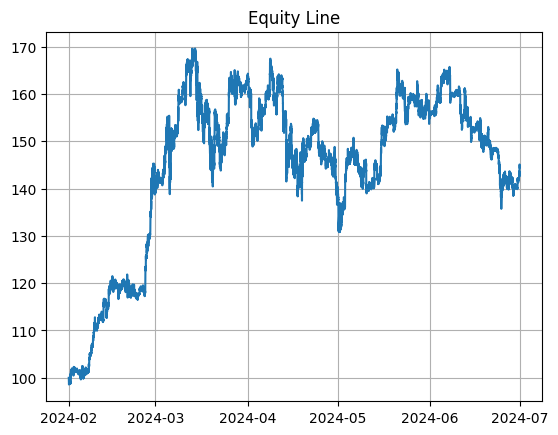

In [347]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni['timestamp'], df_transazioni['valore_totale_portafoglio']);

In [348]:
df_transazioni['azione'].value_counts()

azione
-                 43221
Acquisto            217
Primo acquisto       26
Vendita              25
Name: count, dtype: int64

In [349]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(1.4447137443854448)

In [350]:
indice_ultima_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['timestamp'].idxmax() if "Vendita" in df_transazioni['azione'].unique() else None
indice_ultima_vendita

np.int64(11499)

In [351]:
if indice_ultima_vendita is not None:
    df_transazioni_tagliato_ad_ultima_vendita = df_transazioni[:indice_ultima_vendita+1]
    display(df_transazioni_tagliato_ad_ultima_vendita)

timestamp    prezzo          azione ultima_azione  \
0     2024-02-01 00:00:00  42609.27  Primo acquisto      Acquisto   
1     2024-02-01 00:05:00  42598.05        Acquisto      Acquisto   
2     2024-02-01 00:10:00  42604.33        Acquisto      Acquisto   
3     2024-02-01 00:15:00  42564.96        Acquisto      Acquisto   
4     2024-02-01 00:20:00  42425.66        Acquisto      Acquisto   
...                   ...       ...             ...           ...   
11495 2024-03-11 21:55:00  72515.18               -      Acquisto   
11496 2024-03-11 22:00:00  72565.65               -      Acquisto   
11497 2024-03-11 22:05:00  72578.57               -      Acquisto   
11498 2024-03-11 22:10:00  72571.10               -      Acquisto   
11499 2024-03-11 22:15:00  72676.00         Vendita       Vendita   

       prezzo_medio_pesato_acquisti  liquidità_spesa_o_guadagnata  \
0                      42609.270000                     10.000000   
1                      42603.653360                     10.023699   
2                      42603.879224                     10.032971   
3                      42594.086321                     10.105706   
4                      42559.539792                     10.363556   
...                             ...                           ...   
11495                  71149.723444                      0.000000   
11496                  71149.723444                      0.000000   
11497                  71149.723444                      0.000000   
11498                  71149.723444                      0.000000   
11499                  71149.723444                    164.425513   

       bitcoin_comprati_o_venduti        cash   bitcoin  \
0                        0.000000   90.000000  0.000234   
1                        0.000000   79.976301  0.000470   
2                        0.000000   69.943330  0.000705   
3                        0.000000   59.837623  0.000942   
4                        0.000000   49.474067  0.001186   
...                           ...         ...       ...   
11495                    0.000000    2.805535  0.002265   
11496                    0.000000    2.805535  0.002265   
11497                    0.000000    2.805535  0.002265   
11498                    0.000000    2.805535  0.002265   
11499                    0.002265  167.231048  0.000000   

       valore_totale_portafoglio  
0                      99.990000  
1                      99.977346  
2                      99.970261  
3                      99.932408  
4                      99.790829  
...                          ...  
11495                 167.031427  
11496                 167.145727  
11497                 167.174987  
11498                 167.158070  
11499                 167.231048  

[11500 rows x 10 columns]

In [352]:
if indice_ultima_vendita is not None:
    print(df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[-1] / df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[0])

1.6724777247784723


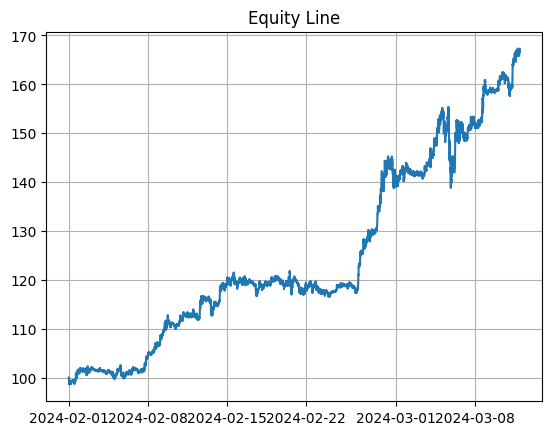

In [353]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni_tagliato_ad_ultima_vendita['timestamp'], df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio']);

In [354]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni_2(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [355]:
crea_grafico_transazioni_2(df_transazioni)

In [356]:
39518.8 / 40194

0.9832014728566454

In [357]:
if indice_ultima_vendita is not None:
    crea_grafico_transazioni_2(df_transazioni_tagliato_ad_ultima_vendita)

C:\Users\alessandro.imbriaco\AppData\Local\Temp\ipykernel_39536\1841209342.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alessandro.imbriaco\AppData\Local\Temp\ipykernel_39536\1841209342.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Strategia 7 (tutti trailing + liquidità mobile e fissa)

In [20]:
def quanto_acquistare(price, first_buy_price, ultimo_acquisto_speso, cash):
    # variazione_primo = abs((price - first_buy_price) / first_buy_price)
    # return min(ultimo_acquisto_speso + variazione_primo * cash, cash)
    return 2 * ultimo_acquisto_speso

In [57]:
def trading_doppio_TS_7(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell, first_trailing_buy_pct,
                              trailing_buy_pct, trailing_sell_pct, first_buy_pct, margin_buy_pct, sure_earn_pct, buy_only_under_last_price, mobile_cash_pct, do_buy):
    # Divisione liquidità iniziale
    mobile_cash = initial_cash * mobile_cash_pct
    fixed_cash = initial_cash * (1 - mobile_cash_pct)
    bitcoin = initial_bitcoin
    last_action = None
    prezzo_medio_pesato_acquisti = 0
    spesa_totale = 0
    trailing_buy_price = None
    trailing_sell_price = None
    transactions = []
    prestiti_fissi = 0

    for idx, row in dati.iterrows():
        timestamp = row['Timestamp']
        price = row['Price']
        action = "-"
        liquidità_spesa_o_guadagnata = 0
        bitcoin_comprati_o_venduti = 0

        # Se l'ultima azione è None o Vendita, dobbiamo impostare un nuovo trailing buy
        if last_action in [None, "Vendita"]:
            if trailing_buy_price is None:
                trailing_buy_price = price * (1 + first_trailing_buy_pct)
            if price >= trailing_buy_price:
                # Primo acquisto
                spesa = mobile_cash * first_buy_pct
                if spesa >= min_buy:
                    bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
                    mobile_cash -= spesa
                    bitcoin += bitcoin_acquistati
                    prezzo_medio_pesato_acquisti = price
                    action = "Primo acquisto"
                    liquidità_spesa_o_guadagnata = spesa
                    bitcoin_comprati_o_venduti = bitcoin_acquistati
                    last_action = "Acquisto"
                    first_buy_price = price
                    last_buy_purchase = spesa
                    trailing_sell_price = prezzo_medio_pesato_acquisti / (
                        (1 - commission_sell_pct) * (1 - trailing_sell_pct) * (1 - sure_earn_pct)
                    )
                    trailing_buy_price = price / ((1 + trailing_buy_pct) * (1 + margin_buy_pct))

        # Se l'ultima azione è Acquisto, valuta trailing buy e trailing sell
        elif last_action == "Acquisto":
            if price >= trailing_sell_price:
                # Vendi tutto
                ricavato = bitcoin * price * (1 - commission_sell_pct)
                if ricavato >= min_sell:
                    mobile_cash += ricavato
                    bitcoin_comprati_o_venduti = bitcoin
                    liquidità_spesa_o_guadagnata = ricavato
                    bitcoin = 0

                    # Restituisci eventuali prestiti a fixed_cash
                    if prestiti_fissi > 0:
                        da_restituire = prestiti_fissi
                        if mobile_cash >= da_restituire:
                          mobile_cash -= da_restituire
                          fixed_cash += da_restituire
                        else:
                            print(f"Errore: non è stato possibile restituire {prestiti_fissi} alla liquidità fissa perchè quella mobile non ha soldi sufficienti (non dovrebbe mai succedere questa cosa, qualcosa non va!).")

                    trailing_sell_price = None
                    trailing_buy_price = None
                    action = "Vendita"
                    last_action = "Vendita"
                    prestiti_fissi = 0
                    prezzo_medio_pesato_acquisti = 0
                    spesa_totale = 0

            elif price <= trailing_buy_price:
                # Acquisto successivo
                spesa = quanto_acquistare(price, first_buy_price, last_buy_purchase, mobile_cash)
                if spesa >= min_buy:
                    if spesa > mobile_cash and fixed_cash - (spesa - mobile_cash) > 0:
                        prestito = spesa - mobile_cash
                        fixed_cash -= prestito
                        prestiti_fissi += prestito
                        mobile_cash += prestito
                    elif spesa > mobile_cash and fixed_cash - (spesa - mobile_cash) <= 0:
                      if do_buy:
                        prestito = fixed_cash
                        fixed_cash -= prestito
                        prestiti_fissi += prestito
                        mobile_cash += prestito

                    if spesa > mobile_cash and do_buy:
                      spesa = mobile_cash
                      
                    if spesa <= mobile_cash:
                        bitcoin_acquistati = spesa * (1 - commission_buy_pct) / price
                        mobile_cash -= spesa
                        bitcoin += bitcoin_acquistati
                        last_buy_purchase = price
                        action = "Acquisto"
                        liquidità_spesa_o_guadagnata = spesa
                        bitcoin_comprati_o_venduti = bitcoin_acquistati
                        prezzo_medio_pesato_acquisti = (
                            prezzo_medio_pesato_acquisti * spesa_totale + price * spesa
                        ) / (spesa_totale + spesa)
                        spesa_totale += spesa
                        trailing_sell_price = prezzo_medio_pesato_acquisti / (
                            (1 - commission_sell_pct) * (1 - trailing_sell_pct) * (1 - sure_earn_pct)
                        )
                        trailing_buy_price = last_buy_purchase / ((1 + trailing_buy_pct) * (1 + margin_buy_pct)) if buy_only_under_last_price else prezzo_medio_pesato_acquisti / ((1 + trailing_buy_pct) * (1 + margin_buy_pct))

        # Valore totale del portafoglio
        portfolio_value = mobile_cash + fixed_cash + bitcoin * price

        # Aggiungi la transazione
        transactions.append({
            "timestamp": timestamp, "prezzo": price, "azione": action, "ultima_azione": last_action,
            "trailing_buy_price": trailing_buy_price, "trailing_sell_price": trailing_sell_price,
            "prezzo_medio_pesato_acquisti": prezzo_medio_pesato_acquisti,
            "liquidità_spesa_o_guadagnata": liquidità_spesa_o_guadagnata,
            "bitcoin_comprati_o_venduti": bitcoin_comprati_o_venduti, "liquidità_mobile": mobile_cash,
            "liquidità_fissa": fixed_cash, "bitcoin": bitcoin,
            "valore_totale_portafoglio": portfolio_value
        })

    # Restituisci il dataframe delle transazioni
    return pd.DataFrame(transactions)

In [58]:
initial_cash = 1000
initial_bitcoin = 0
commission_buy_pct = 0.001 # 0.1% commissione acquisto
commission_sell_pct = 0.001 # 0.1% commissione vendita
min_buy = 5 # Prezzo minimo di acquisto
min_sell = 5 # Prezzo minimo di vendita
first_trailing_buy_pct = 0.001
trailing_buy_pct = 0.005
trailing_sell_pct = 0.001
first_buy_pct = 0.1
margin_buy_pct = 0.005
sure_earn_pct = 0.001
buy_only_under_last_price = False # Se True, compra solo se il prezzo è inferiore al prezzo dell'ultimo acquisto, altrimenti compra solo sotto il prezzo medio pesato degli acquisti
mobile_cash_pct = 0.1
do_buy = True # Sarebbe il compra_pure, che se è True e l'acquisto è superiore alla liquidità disponibile, usa tutta la liquidità, altrimenti non fa niente

df_transazioni = trading_doppio_TS_7(dati, initial_cash, initial_bitcoin, commission_buy_pct, commission_sell_pct, min_buy, min_sell, first_trailing_buy_pct,
                              trailing_buy_pct, trailing_sell_pct, first_buy_pct, margin_buy_pct, sure_earn_pct, buy_only_under_last_price, mobile_cash_pct, do_buy)
df_transazioni

timestamp    prezzo azione ultima_azione  trailing_buy_price  \
0    2024-02-01 00:00:00  42478.04      -          None         42520.51804   
1    2024-02-01 01:00:00  41983.35      -          None         42520.51804   
2    2024-02-01 02:00:00  42166.17      -          None         42520.51804   
3    2024-02-01 03:00:00  42012.96      -          None         42520.51804   
4    2024-02-01 04:00:00  42075.84      -          None         42520.51804   
...                  ...       ...    ...           ...                 ...   
3620 2024-06-30 20:00:00  61974.39      -       Vendita         70045.31534   
3621 2024-06-30 21:00:00  61933.64      -       Vendita         70045.31534   
3622 2024-06-30 22:00:00  62890.12      -       Vendita         70045.31534   
3623 2024-06-30 23:00:00  62772.83      -       Vendita         70045.31534   
3624 2024-07-01 00:00:00  62935.89      -       Vendita         70045.31534   

      trailing_sell_price  prezzo_medio_pesato_acquisti  \
0                     NaN                           0.0   
1                     NaN                           0.0   
2                     NaN                           0.0   
3                     NaN                           0.0   
4                     NaN                           0.0   
...                   ...                           ...   
3620                  NaN                           0.0   
3621                  NaN                           0.0   
3622                  NaN                           0.0   
3623                  NaN                           0.0   
3624                  NaN                           0.0   

      liquidità_spesa_o_guadagnata  bitcoin_comprati_o_venduti  \
0                              0.0                         0.0   
1                              0.0                         0.0   
2                              0.0                         0.0   
3                              0.0                         0.0   
4                              0.0                         0.0   
...                            ...                         ...   
3620                           0.0                         0.0   
3621                           0.0                         0.0   
3622                           0.0                         0.0   
3623                           0.0                         0.0   
3624                           0.0                         0.0   

      liquidità_mobile  liquidità_fissa  bitcoin  valore_totale_portafoglio  
0           100.000000            900.0      0.0                1000.000000  
1           100.000000            900.0      0.0                1000.000000  
2           100.000000            900.0      0.0                1000.000000  
3           100.000000            900.0      0.0                1000.000000  
4           100.000000            900.0      0.0                1000.000000  
...                ...              ...      ...                        ...  
3620        155.272356            900.0      0.0                1055.272356  
3621        155.272356            900.0      0.0                1055.272356  
3622        155.272356            900.0      0.0                1055.272356  
3623        155.272356            900.0      0.0                1055.272356  
3624        155.272356            900.0      0.0                1055.272356  

[3625 rows x 13 columns]

In [72]:
mdp.calcola_principali_metriche(df_transazioni['valore_totale_portafoglio'], df_transazioni['prezzo'], df_transazioni['bitcoin'])

{'Total Return %': np.float64(5.527235641525476),
 'Max Drawdown': 14.530274825424955,
 'Volatility': np.float64(0.04771071761086138),
 'Sharpe Ratio': np.float64(0.10232395708628829),
 'Sortino Ratio': np.float64(0.14290105130506636),
 'Calmar Ratio': np.float64(0.3803944321723334),
 'Profit Factor': np.float64(137.09478442667157),
 'PnL': np.float64(0.8691742863717709)}

In [69]:
df_transazioni[df_transazioni['azione'] != '-']

timestamp    prezzo          azione ultima_azione  \
14   2024-02-01 14:00:00  42649.97  Primo acquisto      Acquisto   
17   2024-02-01 17:00:00  42921.64         Vendita       Vendita   
19   2024-02-01 19:00:00  43216.98  Primo acquisto      Acquisto   
37   2024-02-02 13:00:00  42692.83        Acquisto      Acquisto   
39   2024-02-02 15:00:00  43237.91         Vendita       Vendita   
...                  ...       ...             ...           ...   
3058 2024-06-07 10:00:00  71372.70  Primo acquisto      Acquisto   
3059 2024-06-07 11:00:00  71709.80         Vendita       Vendita   
3061 2024-06-07 13:00:00  71530.76  Primo acquisto      Acquisto   
3065 2024-06-07 17:00:00  69803.41        Acquisto      Acquisto   
3135 2024-06-10 15:00:00  70061.49         Vendita       Vendita   

      trailing_buy_price  trailing_sell_price  prezzo_medio_pesato_acquisti  \
14          42226.647855         42778.176237                      42649.97   
17                   NaN                  NaN                          0.00   
19          42788.029999         43346.890675                      43216.98   
37          42269.082448         42821.165075                      42692.83   
39                   NaN                  NaN                          0.00   
...                  ...                  ...                           ...   
3058        70664.290488         71587.247051                      71372.70   
3059                 NaN                  NaN                          0.00   
3061        70820.781664         71745.782181                      71530.76   
3065        69110.576471         70013.239750                      69803.41   
3135                 NaN                  NaN                          0.00   

      liquidità_spesa_o_guadagnata  bitcoin_comprati_o_venduti  \
14                       10.000000                    0.000234   
17                       10.043580                    0.000234   
19                       10.004358                    0.000231   
37                       20.008716                    0.000468   
39                       30.212864                    0.000699   
...                            ...                         ...   
3058                     15.552753                    0.000218   
3059                     15.594974                    0.000218   
3061                     15.556975                    0.000217   
3065                     31.113951                    0.000445   
3135                     46.373529                    0.000663   

      liquidità_mobile  liquidità_fissa   bitcoin  valore_totale_portafoglio  
14           90.000000            900.0  0.000234                 999.990000  
17          100.043580            900.0  0.000000                1000.043580  
19           90.039222            900.0  0.000231                1000.033576  
37           70.030506            900.0  0.000699                 999.892352  
39          100.243370            900.0  0.000000                1000.243370  
...                ...              ...       ...                        ...  
3058        139.974780            900.0  0.000218                1055.511980  
3059        155.569753            900.0  0.000000                1055.569753  
3061        140.012778            900.0  0.000217                1055.554196  
3065        108.898827            900.0  0.000663                1055.147783  
3135        155.272356            900.0  0.000000                1055.272356  

[835 rows x 13 columns]

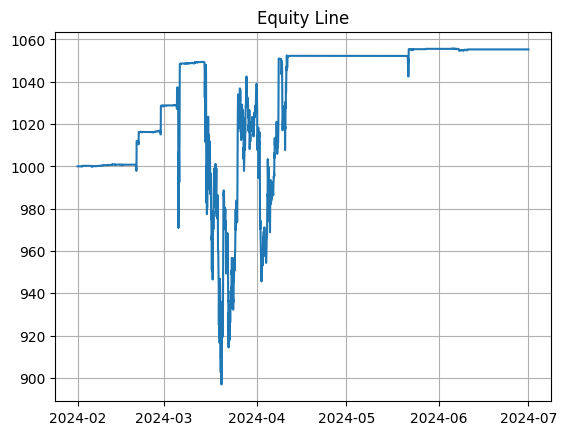

In [59]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni['timestamp'], df_transazioni['valore_totale_portafoglio']);

In [60]:
df_transazioni['azione'].value_counts()

azione
-                 2790
Acquisto           663
Primo acquisto      86
Vendita             86
Name: count, dtype: int64

In [61]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(1.0552723564152549)

In [62]:
indice_ultima_vendita = df_transazioni[df_transazioni['azione'] == 'Vendita']['timestamp'].idxmax() if "Vendita" in df_transazioni['azione'].unique() else None
indice_ultima_vendita

np.int64(3135)

In [63]:
if indice_ultima_vendita is not None:
    df_transazioni_tagliato_ad_ultima_vendita = df_transazioni[:indice_ultima_vendita+1]
    display(df_transazioni_tagliato_ad_ultima_vendita)

timestamp    prezzo   azione ultima_azione  trailing_buy_price  \
0    2024-02-01 00:00:00  42478.04        -          None        42520.518040   
1    2024-02-01 01:00:00  41983.35        -          None        42520.518040   
2    2024-02-01 02:00:00  42166.17        -          None        42520.518040   
3    2024-02-01 03:00:00  42012.96        -          None        42520.518040   
4    2024-02-01 04:00:00  42075.84        -          None        42520.518040   
...                  ...       ...      ...           ...                 ...   
3131 2024-06-10 11:00:00  69469.36        -      Acquisto        69110.576471   
3132 2024-06-10 12:00:00  69368.44        -      Acquisto        69110.576471   
3133 2024-06-10 13:00:00  69409.32        -      Acquisto        69110.576471   
3134 2024-06-10 14:00:00  69673.43        -      Acquisto        69110.576471   
3135 2024-06-10 15:00:00  70061.49  Vendita       Vendita                 NaN   

      trailing_sell_price  prezzo_medio_pesato_acquisti  \
0                     NaN                          0.00   
1                     NaN                          0.00   
2                     NaN                          0.00   
3                     NaN                          0.00   
4                     NaN                          0.00   
...                   ...                           ...   
3131          70013.23975                      69803.41   
3132          70013.23975                      69803.41   
3133          70013.23975                      69803.41   
3134          70013.23975                      69803.41   
3135                  NaN                          0.00   

      liquidità_spesa_o_guadagnata  bitcoin_comprati_o_venduti  \
0                         0.000000                    0.000000   
1                         0.000000                    0.000000   
2                         0.000000                    0.000000   
3                         0.000000                    0.000000   
4                         0.000000                    0.000000   
...                            ...                         ...   
3131                      0.000000                    0.000000   
3132                      0.000000                    0.000000   
3133                      0.000000                    0.000000   
3134                      0.000000                    0.000000   
3135                     46.373529                    0.000663   

      liquidità_mobile  liquidità_fissa   bitcoin  valore_totale_portafoglio  
0           100.000000            900.0  0.000000                1000.000000  
1           100.000000            900.0  0.000000                1000.000000  
2           100.000000            900.0  0.000000                1000.000000  
3           100.000000            900.0  0.000000                1000.000000  
4           100.000000            900.0  0.000000                1000.000000  
...                ...              ...       ...                        ...  
3131        108.898827            900.0  0.000663                1054.926455  
3132        108.898827            900.0  0.000663                1054.859589  
3133        108.898827            900.0  0.000663                1054.886675  
3134        108.898827            900.0  0.000663                1055.061663  
3135        155.272356            900.0  0.000000                1055.272356  

[3136 rows x 13 columns]

In [64]:
if indice_ultima_vendita is not None:
    print(df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[-1] / df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio'].iloc[0])

1.0552723564152549


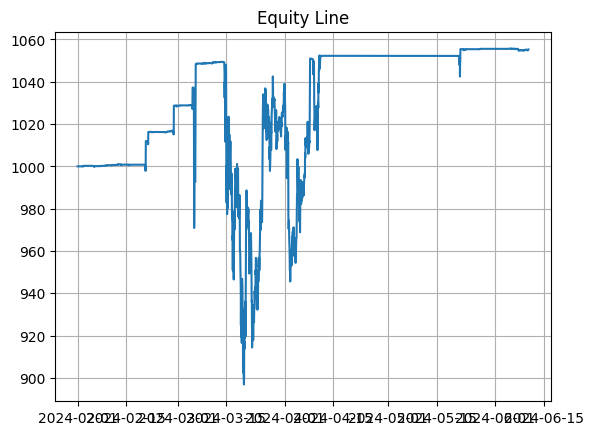

In [65]:
plt.title('Equity Line')
plt.grid()
plt.plot(df_transazioni_tagliato_ad_ultima_vendita['timestamp'], df_transazioni_tagliato_ad_ultima_vendita['valore_totale_portafoglio']);

In [66]:
# Funzione per creare il grafico delle transazioni
def crea_grafico_transazioni_2(df_transazioni):
    # Gestione NaN per sicurezza
    df_transazioni['bitcoin_comprati_o_venduti'] = pd.to_numeric(df_transazioni['bitcoin_comprati_o_venduti'], errors='coerce')
    df_transazioni['liquidità_spesa_o_guadagnata'] = pd.to_numeric(df_transazioni['liquidità_spesa_o_guadagnata'], errors='coerce')

    # Filtra solo le transazioni di vendita e acquisto
    vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']
    acquisti = df_transazioni[(df_transazioni['azione'] == 'Acquisto') | (df_transazioni['azione'] == 'Primo acquisto')]

    # Calcolo della dimensione dei punti per le vendite e gli acquisti
    max_quantita_vendita = vendite['bitcoin_comprati_o_venduti'].abs().max()
    max_quantita_acquisto = acquisti['liquidità_spesa_o_guadagnata'].max()

    def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
        return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

    # Applica la funzione di dimensione per ogni punto vendita e acquisto
    dimensioni_vendite = vendite['bitcoin_comprati_o_venduti'].abs().apply(lambda x: calcola_dimensione(x, max_quantita_vendita))
    dimensioni_acquisti = acquisti['liquidità_spesa_o_guadagnata'].apply(lambda x: calcola_dimensione(x, max_quantita_acquisto))

    # Funzione per creare una stringa di hover con tutte le colonne
    def crea_hover_text(df):
        hover_texts = []
        for _, row in df.iterrows():
            hover_text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
            hover_texts.append(hover_text)
        return hover_texts

    # Creazione del grafico
    fig = go.Figure()

    # Linea dell'andamento dei prezzi
    fig.add_trace(go.Scatter(
        x=df_transazioni['timestamp'],
        y=df_transazioni['prezzo'],
        mode='lines',
        name='Prezzi Bitcoin',
        line=dict(color='blue', width=2),
        hoverinfo='x+y'
    ))

    # Scatter plot per le vendite
    fig.add_trace(go.Scatter(
        x=vendite['timestamp'],
        y=vendite['prezzo'],
        mode='markers',
        name='Vendite',
        marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
        text=crea_hover_text(vendite),
        hoverinfo='text'
    ))

    # Scatter plot per gli acquisti
    fig.add_trace(go.Scatter(
        x=acquisti['timestamp'],
        y=acquisti['prezzo'],
        mode='markers',
        name='Acquisti',
        marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
        text=crea_hover_text(acquisti),
        hoverinfo='text'
    ))

    # Configurazione del layout
    fig.update_layout(
        title='Andamento Prezzi Bitcoin, Transazioni di Vendita e Acquisto',
        xaxis_title='Data',
        yaxis_title='Prezzo (€)',
        hovermode='closest',
        template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        width=1200,
        height=800,
        xaxis=dict(
            rangeslider=dict(visible=True),  # Abilita il range slider
            type="date"  # Imposta l'asse x come asse temporale
        )
    )

    # Mostra il grafico
    fig.show()

In [67]:
crea_grafico_transazioni_2(df_transazioni)

In [68]:
if indice_ultima_vendita is not None:
    crea_grafico_transazioni_2(df_transazioni_tagliato_ad_ultima_vendita)

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_105648\1841209342.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_105648\1841209342.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

